This notebook contains descriptive data analysis and pre-processing and application of ML techniques to predict hospital infection by fungus or bacteria among COVID-19 positeve patients.


In [344]:
# Última modificação: 19/04/2024

In [345]:
!pip install tensorflow
!pip install shap
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [346]:
# Libraries
import numpy as np
import pandas as pd
import random as rd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import os
import time
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, SelectPercentile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer, roc_auc_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer

In [347]:
!pip install 'openpyxl>=3.0.0'

Defaulting to user installation because normal site-packages is not writeable


  # 1.0 - Data integration





















In [348]:
# Checks the existence of the file and, if necessary, goes to the correct directory
verifica_arquivo = os.path.exists("Datasets")
if verifica_arquivo == False:
    %cd /home/filipe/Documentos/GitHub/HCAI_prediction/DatasetConstruction

%ls

/home/filipe/Documentos/GitHub/HCAI_prediction/DatasetConstruction


agrupado.xlsx                     hosp1_sen.csv
Covid_exploratory_analysis.ipynb  hosp1_spe.csv
Dataset_construction.ipynb        lista_covid_positivo.xlsx
dataset.csv                       lista_infec_positivo.xlsx
describe.xlsx                     pacientes_negativos.xlsx
exames_COVID19_considerados.xlsx  pacientes_positivos.xlsx
exames_COVID19_todos.xlsx         Patients_selection.ipynb
exames_infeccoes.xlsx             Plots/
hosp1_auc.csv                     RowDatasets/


/home/filipe/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Datasets

In [349]:
# "HSL_Pacientes_4.csv"
df_pacientes = pd.read_csv('RowDatasets/HSL_Pacientes_4.csv', sep='|')
print("df_pacientes...............: ", df_pacientes.shape)

# remove duplicate examples
df_pacientes = df_pacientes.drop_duplicates()
print("df_pacientes sem duplicatos: ", df_pacientes.shape, "\n")

# "HSL_Exames_4.csv" 
df_exames = pd.read_csv('RowDatasets/HSL_Exames_4.csv', sep='|')
print("df_exames..................: ", df_exames.shape)

# removal duplicate examples
df_exames = df_exames.drop_duplicates()
print("df_exames sem duplicatos...: ", df_exames.shape, "\n")

# "Exame.Analito" column create
df_exames["Exame.Analito"] = df_exames["DE_EXAME"]+"."+df_exames["DE_ANALITO"]

# "HSL_Desfechos_4.csv"
df_desfecho = pd.read_csv('RowDatasets/HSL_Desfechos_4.csv', sep='|')
print("df_desfecho................: ", df_desfecho.shape)

# remove duplicate example
df_desfecho = df_desfecho.drop_duplicates()
print("df_desfecho em duplicatos..: ", df_desfecho.shape)

# add 'outcome' column in front of the same "patient id" and "service id"
df_sirio = df_exames.merge(df_desfecho, on = ["ID_PACIENTE", "ID_ATENDIMENTO"], how = "left")
print("\ndf_sirio...................: ", df_sirio.shape)

# SEX and and birth year obtained from HSL PACIENTES spreadsheet
pacientes_2 = df_pacientes[['ID_PACIENTE','AA_NASCIMENTO','IC_SEXO']]

# add aa_nascimento column on dataframe
df_sirio = df_sirio.merge(pacientes_2, on=['ID_PACIENTE'], how='left')
print("Pacientes únicos...........: ", df_sirio["ID_PACIENTE"].nunique(), '\n')

# Exame.Analito column criate
df_sirio["Exame.Analito"] = df_sirio["DE_EXAME"]+"."+df_sirio["DE_ANALITO"]

df_sirio.columns

df_pacientes...............:  (14673, 7)
df_pacientes sem duplicatos:  (14673, 7) 

df_exames..................:  (2952999, 9)
df_exames sem duplicatos...:  (2899573, 9) 

df_desfecho................:  (89937, 8)
df_desfecho em duplicatos..:  (89937, 8)

df_sirio...................:  (2899573, 16)
Pacientes únicos...........:  14673 



Index(['ID_PACIENTE', 'ID_ATENDIMENTO', 'DT_COLETA', 'DE_ORIGEM', 'DE_EXAME',
       'DE_ANALITO', 'DE_RESULTADO', 'CD_UNIDADE', 'DE_VALOR_REFERENCIA',
       'Exame.Analito', 'DT_ATENDIMENTO', 'DE_TIPO_ATENDIMENTO', 'ID_CLINICA',
       'DE_CLINICA', 'DT_DESFECHO', 'DE_DESFECHO', 'AA_NASCIMENTO', 'IC_SEXO'],
      dtype='object')

## Printing reference values for the interest exams 

The grouped spreadsheet contains the reference values for each exam. These values will be used for future data discretization.

In [350]:
%ls

agrupado.xlsx                     hosp1_sen.csv
Covid_exploratory_analysis.ipynb  hosp1_spe.csv
Dataset_construction.ipynb        lista_covid_positivo.xlsx
dataset.csv                       lista_infec_positivo.xlsx
describe.xlsx                     pacientes_negativos.xlsx
exames_COVID19_considerados.xlsx  pacientes_positivos.xlsx
exames_COVID19_todos.xlsx         Patients_selection.ipynb
exames_infeccoes.xlsx             Plots/
hosp1_auc.csv                     RowDatasets/


In [351]:
valor_referencia = df_exames[["DE_ANALITO","DE_EXAME", "CD_UNIDADE", "DE_VALOR_REFERENCIA"]]
agrupado = valor_referencia.groupby("DE_ANALITO")
agrupado = agrupado.first()

print(agrupado.shape)

agrupado.colums = ["analito", "exame", "unidade", "referencia"]

agrupado.to_excel("agrupado.xlsx")

(1089, 3)


/tmp/ipykernel_7198/3142648951.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  agrupado.colums = ["analito", "exame", "unidade", "referencia"]


In [352]:
agrupado = pd.read_excel("agrupado.xlsx")
agrupado.head()

,DE_ANALITO,DE_EXAME,CD_UNIDADE,DE_VALOR_REFERENCIA
0,11-Desoxicorticosterona,"11-DESOXICORTIcosterona, soro",ng/dL,Até 25
1,11-Desoxicortisol,Composto S,-,-
2,17-Alfa-Hidroxiprog.,17 Alfa Hidroxiprogesterona,ng/dL,Ver resultado tradicional
3,17-Hidroxi Pregnenolona,17 Hidroxipregnenolona,ng/dL,Ver resultado tradicional
4,183,Amilase,U/L,28 a 100


In [353]:
exs = ['ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP/INR',
       'TTPA - Paciente/Normal', 'Uréia', 'VCM', 'Volume plaquetário médio']

In [354]:
for index, row in agrupado.iterrows():
  if row['DE_ANALITO'] not in exs:
    agrupado.drop(index, inplace=True)

agrupado.to_excel("agrupado.xlsx")
    

# 2.0 - PATIENT EXCLUSION CRITERIA

## Only selected patients remain in the dataset construction

Positive patients

In [355]:
%ls

agrupado.xlsx                     hosp1_sen.csv
Covid_exploratory_analysis.ipynb  hosp1_spe.csv
Dataset_construction.ipynb        lista_covid_positivo.xlsx
dataset.csv                       lista_infec_positivo.xlsx
describe.xlsx                     pacientes_negativos.xlsx
exames_COVID19_considerados.xlsx  pacientes_positivos.xlsx
exames_COVID19_todos.xlsx         Patients_selection.ipynb
exames_infeccoes.xlsx             Plots/
hosp1_auc.csv                     RowDatasets/


In [356]:
# positive patients spreadsheet import
df_pacientes_positivos = pd.read_excel('pacientes_positivos.xlsx')

# column to list transform
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()
print("Lista pacientes positivos: ", len(lista_pacientes), "\n")

# removal non positive patients
df2 = df_sirio.copy(deep=True)
df2 = df2.loc[ df2['ID_PACIENTE'].isin(lista_pacientes) ]
print("dataframe 2.....: ", df2.shape)
print("Pacientes únicos: ", df2["ID_PACIENTE"].nunique())

df2.head()

Lista pacientes positivos:  168 

dataframe 2.....:  (551981, 18)
Pacientes únicos:  168


,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO
227,BD4E4C280060926EE89BD4EBAF4A93B9,5A7091BD926E68D0685D8C647DF5215F,13/11/2020,Unidades de Internação,"Acido Ascorbico, plasma","Ácido ascorbico, plasma","0,3",mg/dL,"0,4 a 2,0","Acido Ascorbico, plasma.Ácido ascorbico, plasma",21/10/2020,Internado,1.0,Clínica Médica,23/11/2020,Alta médica melhorado,1942,M
276,744BB1E59B08C85CBCCB483604622A26,064A528D5DBD51DE1EB619DC382D547E,10/01/2021,UTI,"Acido Ascorbico, plasma","Ácido ascorbico, plasma","inferior a 0,25",mg/dL,"0,4 a 2,0","Acido Ascorbico, plasma.Ácido ascorbico, plasma",24/09/2020,Internado,1.0,Clínica Médica,DDMMAA,Óbito após 48hs de internação sem necrópsia,1941,M
286,966F5B1255E6C2AFF91FBAD12D62D3DB,1129AE23E589D734F12F1C027564723A,23/02/2021,Unidades de Internação,Acido Fólico,Ácido fólico,"19,8",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,23/02/2021,Internado,1.0,Clínica Médica,DDMMAA,Óbito após 48hs de internação sem necrópsia,1965,F
292,369C7BA557BDD9BD5A50EA5059A6C012,608E5E827F75BB92250DCA5DAD70C383,25/08/2020,Hemodiálise,Acido Fólico,Ácido fólico,"10,2",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,24/08/2020,Ambulatorial,15.0,Hemodiálise,25/08/2020,Alta Administrativa,1935,M
294,68E0B877774D5769A7898A1DDBF882F2,ED0D85C5897B8123BE511F45E9E401ED,04/04/2020,Hemodiálise,Acido Fólico,Ácido fólico,"5,9",ng/mL,"Maior que 5,4",Acido Fólico.Ácido fólico,16/03/2020,Ambulatorial,15.0,Hemodiálise,14/04/2020,Alta Administrativa,1936,M


Negative patients

In [357]:
# Negative patients spreadsheet import
df_pacientes_negativos = pd.read_excel('pacientes_negativos.xlsx', sheet_name='Sheet1')

# Column to list
lista_pacientes = df_pacientes_negativos[0].values.tolist()
print("Lista pacientes negativos: ", len(lista_pacientes), "\n")

# Eliminated non negative patients
df2_neg = df_sirio.copy(deep=True)
df2_neg = df2_neg.loc[ df2_neg['ID_PACIENTE'].isin(lista_pacientes) ]
print("dataframe 2.....: ", df2_neg.shape)
print("Pacientes únicos: ", df2_neg["ID_PACIENTE"].nunique())

df2_neg.head()

Lista pacientes negativos:  1069 

dataframe 2.....:  (1089297, 18)
Pacientes únicos:  1069


,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO
0,9BB15EA1D912994DE467C71E953F6ACC,E7E88B60259AD5C9CF3A837260CB8CC7,22/01/2021,Hemodiálise,17 Hidroxipregnenolona,17-Hidroxi Pregnenolona,23,ng/dL,Ver resultado tradicional,17 Hidroxipregnenolona.17-Hidroxi Pregnenolona,18/01/2021,Ambulatorial,15.0,Hemodiálise,22/01/2021,Alta Administrativa,1987,F
14,4F17477E5C721FC0BBE302FD5A448270,6B94F8D5766F021A5F21B583BB6B92E5,11/12/2020,Laboratório de Patologia Clínica,"Acetilcolina, Anticorpo Anti",Acetilcolina,"11,0",mmol/L,"Menor ou igual a 0,02","Acetilcolina, Anticorpo Anti.Acetilcolina",11/12/2020,Externo,20.0,Procedimentos,11/12/2020,Alta Administrativa,1953,M
17,B8DC44F94CAA79BB1B5CCC951F59489A,077BCC1089F40147207B0CCB6C076EA1,24/04/2021,Unidades de Internação,"Acetilcolina, Anticorpo Anti",Acetilcolina,"inferior a 0,02",mmol/L,"Menor ou igual a 0,02","Acetilcolina, Anticorpo Anti.Acetilcolina",23/04/2021,Internado,1.0,Clínica Médica,02/05/2021,Alta médica melhorado,1954,M
19,F7C31F677442199344E667CC161AAE5B,BC8DED1CA1C69E1484B1AA899496939A,09/01/2021,Unidades de Internação,"Acetilcolina, Anticorpo Anti",Acetilcolina,"inferior a 0,02",mmol/L,"Menor ou igual a 0,02","Acetilcolina, Anticorpo Anti.Acetilcolina",01/01/2021,Internado,1.0,Clínica Médica,16/01/2021,Alta médica melhorado,1950,M
20,5C4832BBECDDFB9FD2D8C94BB5B2B30A,AE1ECB883EDC595FB42C1412B2F91865,26/10/2020,UTI,"Acetilcolina, Anticorpos Bloqueadores do Recep...",Acetilcolina - Anticorpos bloqueadores,60,%,inferior a 15,"Acetilcolina, Anticorpos Bloqueadores do Recep...",26/10/2020,Internado,1.0,Clínica Médica,26/11/2020,Alta médica melhorado,1945,M


In [358]:
df2 = pd.concat([df2, df2_neg])
df2["ID_PACIENTE"].nunique()

1237

# 3.0 - Exams selection




## 3.1 Colection date

In [359]:
df3 = df2.copy(deep=True)

# date to datetime
df3['DT_ATENDIMENTO'] = pd.to_datetime(df3['DT_ATENDIMENTO'])
df3['DT_COLETA'] = pd.to_datetime(df3['DT_COLETA'])
df3['DT_DESFECHO'] = pd.to_datetime(df3['DT_COLETA'])

# exams period
df3['PERIODO_EXAMES'] = (df3['DT_COLETA']-df3['DT_ATENDIMENTO']).dt.days
print(df3.shape, '\n')

# Exams selection. Select only exames made from 0 to 3 days of internation (0 <= period <= 3) 
df3 = df3[ df3["PERIODO_EXAMES"] >= 0 ]
df3 = df3[ df3["PERIODO_EXAMES"] <= 3 ]
print(df3.shape, '\n')

df3["ID_PACIENTE"].nunique()

/tmp/ipykernel_7198/3363128514.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df3['DT_ATENDIMENTO'] = pd.to_datetime(df3['DT_ATENDIMENTO'])
/tmp/ipykernel_7198/3363128514.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df3['DT_COLETA'] = pd.to_datetime(df3['DT_COLETA'])


(1641278, 19) 

(456247, 19) 



1237

## 3.2 Exams elimination (with more than 50% missing data)

In [360]:
df3_2 = df3.copy(deep=True)

#Considera apenas o último exame no caso de repetidos no mesmo dia.
df3_2 = df3_2.groupby(['ID_PACIENTE', 'PERIODO_EXAMES', 'Exame.Analito']).agg( {'DE_RESULTADO' : ['last'],
                                                    'DE_VALOR_REFERENCIA': ['last']} ).reset_index()
print( df3_2.shape )

#solucionando nome colunas dois niveis
df3_2.columns = [ '_'.join(x) for x in df3_2.columns ]
df3_2.columns=['PACIENTE', 'PERIODO', 'Exame.Analito', 'RESULTADO', 'REFERENCIA']
#df_analise.to_excel('df_analise.xlsx')

# pivot_table
df3_2 = df3_2.pivot_table( index=['PACIENTE'],
                                     columns=['Exame.Analito'],
                                     values=['RESULTADO'],
                                     aggfunc='last' ).reset_index()

#solucionando nome colunas dois niveis
df3_2.columns = [ ''.join(x) for x in df3_2.columns ]
df3_2.head()

(254185, 5)


,PACIENTE,RESULTADO17 Alfa Hidroxiprogesterona.17-Alfa-Hidroxiprog.,"RESULTADOAcetilcolina, Anticorpo Anti.Acetilcolina","RESULTADOAcetilcolina, Anticorpos Bloqueadores do Receptor, soro.Acetilcolina - Anticorpos bloqueadores","RESULTADOAcido Ascorbico, plasma.Ácido ascorbico, plasma",RESULTADOAcido Fólico.Ácido fólico,"RESULTADOAcido Urico, amostra isolada, urina.Relação Ácido Úrico/Creatinina","RESULTADOAcido Urico, amostra isolada, urina.Ácido Úrico, urina isolada",RESULTADOAdenosina Deaminase (ADA).ADA,"RESULTADOAdenovirus, Pesquisa (Fezes).Adenovirus, fezes",...,RESULTADOZinco.Zinco,"RESULTADOÁcido Lático, Sangue Arterial.Lactato, arterial","RESULTADOÁcido Metilmalônico, Soro.Ácido metilmalonico, soro","RESULTADOÁcido Valpróico, Dosagem.Ácido Valpróico","RESULTADOÁcido Vanil Mandélico, Amostra isolada, Urina.Ácido Vanil-Mandélico",RESULTADOÁcido Úrico Urinário.Período de coleta (horas),RESULTADOÁcido Úrico Urinário.Volume (mL),"RESULTADOÁcido Úrico Urinário.Ácido Úrico, urina","RESULTADOÁcido Úrico, soro.Ácido Úrico",RESULTADOÁcido Úrico.Ácido Úrico
0,004688799FD293C3ABE0A07209FD8B75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,5"
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,NaN,NaN,NaN,NaN,"8,8",237,292,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"6,3"
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010AF0C3418C765CDA28B5957210A819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [361]:
teste = df3_2[["PACIENTE","RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais", "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"]]
teste.head()

,PACIENTE,"RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais","RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais"
0,004688799FD293C3ABE0A07209FD8B75,NEGATIVO,NEGATIVO
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,NEGATIVO,NEGATIVO
2,009F0D6B3BA6C0E2D406585697D679EB,NEGATIVO,NEGATIVO
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,NEGATIVO,NEGATIVO
4,010AF0C3418C765CDA28B5957210A819,NaN,NaN


In [362]:
# calcula a porcentagem de valores ausentes
ausentes = df3_2.isnull().sum()
ausentes = pd.DataFrame([ausentes])
ausentes = ausentes.drop(columns=['PACIENTE'])
ausentes = ausentes.T
ausentes['Nulos por cento'] = ''
total_pacientes = df3_2["PACIENTE"].nunique()
for index, row in ausentes.iterrows():
        porcentagem = round((row[0]/total_pacientes)*100, 2)
        ausentes.loc[index,'Nulos por cento'] = porcentagem
ausentes = ausentes.sort_values(by=[0], ascending=False)
ausentes.reset_index(inplace=True, drop=False)
ausentes.columns = ["exame.analito", "valores nulos", "nulos por cento" ]
print(ausentes.shape, '\n')
ausentes

(1139, 3) 



,exame.analito,valores nulos,nulos por cento
0,"RESULTADOSaccharomyces Cerevisiae ( Asca), Ant...",1236,99.92
1,"RESULTADOCOVID-19, anticorpos IGA e IGG, soro....",1236,99.92
2,"RESULTADOCardiolipina, Anticorpos Iga, Plasma....",1236,99.92
3,"RESULTADOCarnitina, Dosagem.Carnitina Livre (CL)",1236,99.92
4,"RESULTADOCarnitina, Dosagem.Carnitina total",1236,99.92
...,...,...,...
1134,RESULTADOHemograma.HCM,14,1.13
1135,RESULTADOHemograma.Eritrócitos,14,1.13
1136,RESULTADOHemograma.Eosinófilos (%),14,1.13
1137,RESULTADOHemograma.Eosinófilos,14,1.13


In [363]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para aeróbios, por maldi-tof, vários materiais.Hemocultura para aeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
1079,"RESULTADOHemocultura para aeróbios, por maldi-...",498,40.26


In [364]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais" ]

,exame.analito,valores nulos,nulos por cento
1078,"RESULTADOHemocultura para anaeróbios, por mald...",501,40.5


In [365]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Aeróbios, Vários Materiais.Hemocultura para Aeróbios" ]

,exame.analito,valores nulos,nulos por cento
905,"RESULTADOHemocultura, para Aeróbios, Vários Ma...",1127,91.11


In [366]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Anaeróbios, Vários Materiais.Hemocultura para Anaeróbios" ]

,exame.analito,valores nulos,nulos por cento
943,"RESULTADOHemocultura, para Anaeróbios, Vários ...",1091,88.2


In [367]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOFungos, Cultura.Fungos, Cultura" ]

,exame.analito,valores nulos,nulos por cento
900,"RESULTADOFungos, Cultura.Fungos, Cultura",1132,91.51


In [368]:
# Exame de interesse
ausentes[ ausentes["exame.analito"] == "RESULTADOHemocultura, para Fungos, Varios Materiais.Hemocultura Fungos" ]

,exame.analito,valores nulos,nulos por cento
849,"RESULTADOHemocultura, para Fungos, Varios Mate...",1180,95.39


In [369]:
# Elimina exames com mais de 50% de valores ausentes
ausentes = ausentes[ ausentes["nulos por cento"] < 50]
print(ausentes.shape, '\n')
ausentes

(79, 3) 



,exame.analito,valores nulos,nulos por cento
1060,RESULTADOPeptideo Natriuretico Tipo B (Bnp).BNP,607,49.07
1061,"RESULTADOUrina, Cultura - Jato Médio.Urina, Cu...",594,48.02
1062,"RESULTADOUrina, Cultura - Jato Médio.Cultura d...",588,47.53
1063,RESULTADODesidrogenase Lática (DHL/L).DHL,583,47.13
1064,"RESULTADOUrina Tipo I - Jato Medio.Glicose, ur...",511,41.31
...,...,...,...
1134,RESULTADOHemograma.HCM,14,1.13
1135,RESULTADOHemograma.Eritrócitos,14,1.13
1136,RESULTADOHemograma.Eosinófilos (%),14,1.13
1137,RESULTADOHemograma.Eosinófilos,14,1.13


In [370]:
# gerando lista de exames com menos de 50% de missing values
temp = ausentes["exame.analito"].unique()
lista_exames = temp.tolist()
print("Tamanho lista de exames com menos de 50% NaN:", len(lista_exames), '\n')

# adquirindo novamente a lista de exames
df_exames_selecionados = pd.read_excel('exames_infeccoes.xlsx', sheet_name='Sheet1')
lista_exames_bac = df_exames_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames bacterias: ", len(lista_exames_bac), '\n')

# adquirindo novamente a lista de exames (COVID)
df_exames_covid_selecionados = pd.read_excel('exames_COVID19_considerados.xlsx', sheet_name='lista_exames')
lista_exames_covid = df_exames_covid_selecionados["Exame.Analito"].values.tolist()
print("\nTamanho lista de exames covid: ", len(lista_exames_covid), '\n')

# retirando a palavra "RESULTADO" do nome dos exames
nova_lista = []
for i in lista_exames:
    nova_lista.append(i[9:])

# juntando listas
for i in lista_exames_bac:
    nova_lista.append(i)
for i in lista_exames_covid:
    nova_lista.append(i)
    print(i)
print('\nTamanho lista final de exames:', len(nova_lista), '\n')

Tamanho lista de exames com menos de 50% NaN: 79 


Tamanho lista de exames bacterias:  6 


Tamanho lista de exames covid:  2 

COVID-19-PCR para SARS-COV-2, Vários Materiais (Fleury).Coronavírus (2019-nCoV)
Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica).Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)

Tamanho lista final de exames: 87 



In [371]:
nova_lista

['Peptideo Natriuretico Tipo B (Bnp).BNP',
 'Urina, Cultura - Jato Médio.Urina, Cultura - Jato Médio - Parcial',
 'Urina, Cultura - Jato Médio.Cultura de Urina',
 'Desidrogenase Lática (DHL/L).DHL',
 'Urina Tipo I - Jato Medio.Glicose, urina isol',
 'Urina Tipo I - Jato Medio.Leucócitos, urina',
 'Urina Tipo I - Jato Medio.Aspecto, urina',
 'Urina Tipo I - Jato Medio.Bilirrubina,urina',
 'Urina Tipo I - Jato Medio.C.Cetônicos, urina',
 'Urina Tipo I - Jato Medio.Cilindros, urina',
 'Urina Tipo I - Jato Medio.pH, urina',
 'Urina Tipo I - Jato Medio.Urobilinogênio,urina',
 'Urina Tipo I - Jato Medio.Proteínas, urina isolada',
 'Urina Tipo I - Jato Medio.Cor, urina',
 'Urina Tipo I - Jato Medio.Células Epiteliais',
 'Urina Tipo I - Jato Medio.Nitrito, urina',
 'Urina Tipo I - Jato Medio.Eritrócitos, urina',
 'Urina Tipo I - Jato Medio.Densidade, urina',
 'Hemocultura para anaeróbios, por maldi-tof, vários materiais.Hemocultura para anaeróbios, por maldi-tof, vários materiais',
 'Hemocultu

In [372]:
# exams selection (only exams from "nova_lista" list)

df3_2 = df3.loc[ df3["Exame.Analito"].isin(nova_lista) ]

df3_2.head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO,PERIODO_EXAMES
13567,966F5B1255E6C2AFF91FBAD12D62D3DB,1129AE23E589D734F12F1C027564723A,2021-02-23,Unidades de Internação,Tgo,AST (TGO),71,U/L,Até 32,Tgo.AST (TGO),2021-02-23,Internado,1.0,Clínica Médica,2021-02-23,Óbito após 48hs de internação sem necrópsia,1965,F,0.0
13603,369C7BA557BDD9BD5A50EA5059A6C012,6B32938AE9FF52EF99738CBE80B3DD72,2020-08-18,Hemodiálise,Tgo,AST (TGO),"16,0",U/L,Até 40,Tgo.AST (TGO),2020-08-17,Ambulatorial,15.0,Hemodiálise,2020-08-18,Alta Administrativa,1935,M,1.0
13611,369C7BA557BDD9BD5A50EA5059A6C012,BF393640439F86F563EDD89C76666A04,2021-03-02,Hemodiálise,Tgo,AST (TGO),"19,0",U/L,Até 40,Tgo.AST (TGO),2021-03-01,Ambulatorial,15.0,Hemodiálise,2021-03-02,Alta Administrativa,1935,M,1.0
13612,369C7BA557BDD9BD5A50EA5059A6C012,608E5E827F75BB92250DCA5DAD70C383,2020-08-25,Hemodiálise,Tgo,AST (TGO),"15,0",U/L,Até 40,Tgo.AST (TGO),2020-08-24,Ambulatorial,15.0,Hemodiálise,2020-08-25,Alta Administrativa,1935,M,1.0
13631,DDA7A32DC1A9F2A19B14F8AFEC5D3A8B,0ED0B7188D4F504BA2D59A8906EA2FED,2021-02-16,Hemodiálise,Tgo,AST (TGO),"14,0",U/L,Até 40,Tgo.AST (TGO),2021-02-15,Ambulatorial,15.0,Hemodiálise,2021-02-16,Alta Administrativa,1935,M,1.0


In [373]:
df3_2["ID_PACIENTE"].nunique()

1237

## 3.3 Non numerical exams elimination

In [374]:
df3_3 = df3_2.copy(deep=True)

# replace ',' por '.'.
df3_3['DE_RESULTADO'] = [x.replace(',', '.') for x in df3_3['DE_RESULTADO']] 

df3_3.head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO,PERIODO_EXAMES
13567,966F5B1255E6C2AFF91FBAD12D62D3DB,1129AE23E589D734F12F1C027564723A,2021-02-23,Unidades de Internação,Tgo,AST (TGO),71,U/L,Até 32,Tgo.AST (TGO),2021-02-23,Internado,1.0,Clínica Médica,2021-02-23,Óbito após 48hs de internação sem necrópsia,1965,F,0.0
13603,369C7BA557BDD9BD5A50EA5059A6C012,6B32938AE9FF52EF99738CBE80B3DD72,2020-08-18,Hemodiálise,Tgo,AST (TGO),16.0,U/L,Até 40,Tgo.AST (TGO),2020-08-17,Ambulatorial,15.0,Hemodiálise,2020-08-18,Alta Administrativa,1935,M,1.0
13611,369C7BA557BDD9BD5A50EA5059A6C012,BF393640439F86F563EDD89C76666A04,2021-03-02,Hemodiálise,Tgo,AST (TGO),19.0,U/L,Até 40,Tgo.AST (TGO),2021-03-01,Ambulatorial,15.0,Hemodiálise,2021-03-02,Alta Administrativa,1935,M,1.0
13612,369C7BA557BDD9BD5A50EA5059A6C012,608E5E827F75BB92250DCA5DAD70C383,2020-08-25,Hemodiálise,Tgo,AST (TGO),15.0,U/L,Até 40,Tgo.AST (TGO),2020-08-24,Ambulatorial,15.0,Hemodiálise,2020-08-25,Alta Administrativa,1935,M,1.0
13631,DDA7A32DC1A9F2A19B14F8AFEC5D3A8B,0ED0B7188D4F504BA2D59A8906EA2FED,2021-02-16,Hemodiálise,Tgo,AST (TGO),14.0,U/L,Até 40,Tgo.AST (TGO),2021-02-15,Ambulatorial,15.0,Hemodiálise,2021-02-16,Alta Administrativa,1935,M,1.0


In [375]:
# function to verify if the variable is numeric

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# function test
print( is_number("99.99") )
print( is_number("1") )
print( is_number("A") )


True
True
False


In [376]:
# new column
df3_3['Tipo_resultado'] = np.nan

# fuction to label numerical or non numerical
def numerico(x):
    return is_number(x['DE_RESULTADO'])

# call function
df3_3['Tipo_resultado'] = df3_3.apply( lambda row : numerico(row), axis = 1)

df3_3.head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO,PERIODO_EXAMES,Tipo_resultado
13567,966F5B1255E6C2AFF91FBAD12D62D3DB,1129AE23E589D734F12F1C027564723A,2021-02-23,Unidades de Internação,Tgo,AST (TGO),71,U/L,Até 32,Tgo.AST (TGO),2021-02-23,Internado,1.0,Clínica Médica,2021-02-23,Óbito após 48hs de internação sem necrópsia,1965,F,0.0,True
13603,369C7BA557BDD9BD5A50EA5059A6C012,6B32938AE9FF52EF99738CBE80B3DD72,2020-08-18,Hemodiálise,Tgo,AST (TGO),16.0,U/L,Até 40,Tgo.AST (TGO),2020-08-17,Ambulatorial,15.0,Hemodiálise,2020-08-18,Alta Administrativa,1935,M,1.0,True
13611,369C7BA557BDD9BD5A50EA5059A6C012,BF393640439F86F563EDD89C76666A04,2021-03-02,Hemodiálise,Tgo,AST (TGO),19.0,U/L,Até 40,Tgo.AST (TGO),2021-03-01,Ambulatorial,15.0,Hemodiálise,2021-03-02,Alta Administrativa,1935,M,1.0,True
13612,369C7BA557BDD9BD5A50EA5059A6C012,608E5E827F75BB92250DCA5DAD70C383,2020-08-25,Hemodiálise,Tgo,AST (TGO),15.0,U/L,Até 40,Tgo.AST (TGO),2020-08-24,Ambulatorial,15.0,Hemodiálise,2020-08-25,Alta Administrativa,1935,M,1.0,True
13631,DDA7A32DC1A9F2A19B14F8AFEC5D3A8B,0ED0B7188D4F504BA2D59A8906EA2FED,2021-02-16,Hemodiálise,Tgo,AST (TGO),14.0,U/L,Até 40,Tgo.AST (TGO),2021-02-15,Ambulatorial,15.0,Hemodiálise,2021-02-16,Alta Administrativa,1935,M,1.0,True


In [377]:
df3_3[ df3_3["Tipo_resultado"] == False].head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO,PERIODO_EXAMES,Tipo_resultado
48331,9D916B5C9C35FEF3EE8C15561F552F9C,002C2ED4E95D66A087D45586C2A05D08,2021-02-13,UTI,"Fibrinogênio, Dosagem Do",Fibrinogenio,superior a 1200,mg/dL,200 a 400,"Fibrinogênio, Dosagem Do.Fibrinogenio",2021-02-10,Internado,1.0,Clínica Médica,2021-02-13,Alta médica melhorado,1966,M,3.0,False
177358,AC0017CDB4B2E8E2AA46946B483670A6,B1C2762074F0738631303ADB24BF90AF,2021-03-07,UTI,Gasometria Venosa,BE venoso,*,-,"-3,0 a +3,0",Gasometria Venosa.BE venoso,2021-03-05,Internado,2.0,Cirurgia,2021-03-07,Alta médica melhorado,AAAA,F,2.0,False
205085,AC0017CDB4B2E8E2AA46946B483670A6,B1C2762074F0738631303ADB24BF90AF,2021-03-07,UTI,Gasometria Venosa,Sat O2 venoso,*,%,60 a 85,Gasometria Venosa.Sat O2 venoso,2021-03-05,Internado,2.0,Cirurgia,2021-03-07,Alta médica melhorado,AAAA,F,2.0,False
223345,AC0017CDB4B2E8E2AA46946B483670A6,B1C2762074F0738631303ADB24BF90AF,2021-03-06,Centro Cirurgico,Gasometria Venosa,pO2 venoso,*,mmHg,30 a 50,Gasometria Venosa.pO2 venoso,2021-03-05,Internado,2.0,Cirurgia,2021-03-06,Alta médica melhorado,AAAA,F,1.0,False
308834,420093DC50A71CB9B0C5E87729FF03B2,2B1827770EC8ECD1B1C99C56DBD2431C,2021-04-24,Unidades de Internação,"Calculo da Estimativa da Taxa, de Filtracao Gl...",Cálculo p/afrodescendente MDRD,superior a 60,mL/minuto,Superior a 60,"Calculo da Estimativa da Taxa, de Filtracao Gl...",2021-04-23,Internado,29.0,Outros,2021-04-24,Alta médica melhorado,1957,F,1.0,False


In [378]:
# drop non numerical
df3_3.drop(df3_3.loc[df3_3['Tipo_resultado']==False].index, inplace=True)

In [379]:
df3_3[ df3_3["Tipo_resultado"] == False]

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA,Exame.Analito,DT_ATENDIMENTO,DE_TIPO_ATENDIMENTO,ID_CLINICA,DE_CLINICA,DT_DESFECHO,DE_DESFECHO,AA_NASCIMENTO,IC_SEXO,PERIODO_EXAMES,Tipo_resultado


In [380]:
df3_3["ID_PACIENTE"].nunique()

1233

In [381]:
# Converte resultado de string para float
df3_3['DE_RESULTADO'] = df3_3['DE_RESULTADO'].astype(float) 

In [382]:
df3_3["ID_PACIENTE"].nunique()

1233

# 4.0 - GROUPBY 

In [383]:
df4 = df3_3.copy(deep=True)

# Only considers the last exam in the case of repeat exams
df4 = df4.groupby(['ID_PACIENTE','AA_NASCIMENTO','IC_SEXO','DE_ANALITO']).agg({'DT_COLETA': ['max'], 'DE_RESULTADO' : ['last']}).reset_index()

df4.head(3)


,ID_PACIENTE,AA_NASCIMENTO,IC_SEXO,DE_ANALITO,DT_COLETA,DE_RESULTADO
,,,,,max,last
0,004688799FD293C3ABE0A07209FD8B75,1953,M,ALT (TGP),2021-05-17,16.0
1,004688799FD293C3ABE0A07209FD8B75,1953,M,AST (TGO),2021-05-17,14.0
2,004688799FD293C3ABE0A07209FD8B75,1953,M,BE venoso,2020-10-24,-3.5


In [384]:
df4.columns = ['ID_PACIENTE', 'Idade','Sexo', 'DE_ANALITO','DT_COLETA', 'DE_RESULTADO']

df4.head(3)

,ID_PACIENTE,Idade,Sexo,DE_ANALITO,DT_COLETA,DE_RESULTADO
0,004688799FD293C3ABE0A07209FD8B75,1953,M,ALT (TGP),2021-05-17,16.0
1,004688799FD293C3ABE0A07209FD8B75,1953,M,AST (TGO),2021-05-17,14.0
2,004688799FD293C3ABE0A07209FD8B75,1953,M,BE venoso,2020-10-24,-3.5


In [385]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61081 entries, 0 to 61080
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID_PACIENTE   61081 non-null  object        
 1   Idade         61081 non-null  object        
 2   Sexo          61081 non-null  object        
 3   DE_ANALITO    61081 non-null  object        
 4   DT_COLETA     61081 non-null  datetime64[ns]
 5   DE_RESULTADO  61081 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 2.8+ MB


In [386]:
df4["ID_PACIENTE"].nunique()

1233

## Transform age equal 'AAAA' or 'YYYY' to np.nan

In [387]:
#df4.drop(df4.loc[df4['Idade']=='AAAA'].index, inplace=True)
#df4.drop(df4.loc[df4['Idade']=='YYYY'].index, inplace=True)

In [388]:
df4.loc[df4['Idade']=='AAAA', 'Idade'] = np.nan
df4.loc[df4['Idade']=='YYYY', 'Idade'] = np.nan


In [389]:
df4[df4['Idade'] == df4['Idade']]

,ID_PACIENTE,Idade,Sexo,DE_ANALITO,DT_COLETA,DE_RESULTADO
0,004688799FD293C3ABE0A07209FD8B75,1953,M,ALT (TGP),2021-05-17,16.0
1,004688799FD293C3ABE0A07209FD8B75,1953,M,AST (TGO),2021-05-17,14.0
2,004688799FD293C3ABE0A07209FD8B75,1953,M,BE venoso,2020-10-24,-3.5
3,004688799FD293C3ABE0A07209FD8B75,1953,M,BNP,2020-09-15,60.0
4,004688799FD293C3ABE0A07209FD8B75,1953,M,Basófilos,2021-05-17,30.0
...,...,...,...,...,...,...
61076,FFF5753408C98D5E0218931420B6AF85,2004,F,Tempo de Protrombina,2020-11-17,12.3
61077,FFF5753408C98D5E0218931420B6AF85,2004,F,Uréia,2020-11-17,27.0
61078,FFF5753408C98D5E0218931420B6AF85,2004,F,VCM,2020-11-17,89.9
61079,FFF5753408C98D5E0218931420B6AF85,2004,F,Volume plaquetário médio,2020-11-17,12.1


In [390]:
df4[df4['Idade'] != df4['Idade']]


,ID_PACIENTE,Idade,Sexo,DE_ANALITO,DT_COLETA,DE_RESULTADO
62,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,M,ALT (TGP),2021-02-21,24.00
63,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,M,AST (TGO),2021-02-21,17.00
64,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,M,BNP,2021-02-18,84.00
65,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,M,Basófilos,2021-02-21,20.00
66,0047AF5116BC8AC8EFE6BBB98DA14DFA,NaN,M,Basófilos (%),2021-02-21,0.20
...,...,...,...,...,...,...
60697,FCB285E2D847F170B2A049D3A7E75E55,NaN,M,Volume plaquetário médio,2021-04-23,9.70
60698,FCB285E2D847F170B2A049D3A7E75E55,NaN,M,pCO2 venoso,2021-04-23,46.00
60699,FCB285E2D847F170B2A049D3A7E75E55,NaN,M,pH venoso,2021-04-23,7.38
60700,FCB285E2D847F170B2A049D3A7E75E55,NaN,M,"pH, urina",2021-04-20,5.00


In [391]:
#df4['Idade'] = df4['Idade'].astype(int)

#df4['Idade'] = 2021 - df4['Idade']

#df4.head(3)

In [392]:
df4

,ID_PACIENTE,Idade,Sexo,DE_ANALITO,DT_COLETA,DE_RESULTADO
0,004688799FD293C3ABE0A07209FD8B75,1953,M,ALT (TGP),2021-05-17,16.0
1,004688799FD293C3ABE0A07209FD8B75,1953,M,AST (TGO),2021-05-17,14.0
2,004688799FD293C3ABE0A07209FD8B75,1953,M,BE venoso,2020-10-24,-3.5
3,004688799FD293C3ABE0A07209FD8B75,1953,M,BNP,2020-09-15,60.0
4,004688799FD293C3ABE0A07209FD8B75,1953,M,Basófilos,2021-05-17,30.0
...,...,...,...,...,...,...
61076,FFF5753408C98D5E0218931420B6AF85,2004,F,Tempo de Protrombina,2020-11-17,12.3
61077,FFF5753408C98D5E0218931420B6AF85,2004,F,Uréia,2020-11-17,27.0
61078,FFF5753408C98D5E0218931420B6AF85,2004,F,VCM,2020-11-17,89.9
61079,FFF5753408C98D5E0218931420B6AF85,2004,F,Volume plaquetário médio,2020-11-17,12.1


In [393]:
df4['ID_PACIENTE'].nunique()

1233

# 5.0 - PIVOTATION FOR EXAMS TO BECOME COLUMNS

In [394]:
df5 = df4.copy(deep=True)

print("\ndataframe df5: ", df5.shape)
print("Pacientes únicos: ", df5["ID_PACIENTE"].nunique(), '\n')


dataframe df5:  (61081, 6)
Pacientes únicos:  1233 



In [395]:
# pivot_table
df5 = df5.pivot_table( index=['ID_PACIENTE', 'Sexo'],
                                     
                        values=['DE_RESULTADO'],
                      
                        columns=['DE_ANALITO'],
                                     
                        aggfunc=['last'] ).reset_index()

df5

ID_PACIENTE Sexo         last            \
                                                  DE_RESULTADO             
DE_ANALITO                                           ALT (TGP) AST (TGO)   
0           004688799FD293C3ABE0A07209FD8B75    M         16.0      14.0   
1           0047AF5116BC8AC8EFE6BBB98DA14DFA    M         24.0      17.0   
2           009F0D6B3BA6C0E2D406585697D679EB    M         25.0      33.0   
3           00DCB2411CFD2F3C9FB4CD35C3AACCA1    M         22.0      26.0   
4           010AF0C3418C765CDA28B5957210A819    F        162.0      94.0   
...                                      ...  ...          ...       ...   
1228        FEC09496E67CD8A4DE225245AF35799C    M          NaN       NaN   
1229        FECC5CE1CFE3BCE881F29C2333527135    F         10.0      15.0   
1230        FF19A1D8C1EB3A7A73541F3443B4FA00    F         15.0      22.0   
1231        FF4B2EED093AE641B9328FDB293C4116    M         35.0      21.0   
1232        FFF5753408C98D5E0218931420B6AF85    F         52.0      47.0   

                                                                        \
                                                                         
DE_ANALITO BE venoso    BNP Basófilos Basófilos (%) Bilirrubina Direta   
0               -3.5   60.0      30.0           0.4               0.20   
1                NaN   84.0      20.0           0.2               0.17   
2                NaN   77.0      20.0           0.2               0.19   
3                7.3  428.0      20.0           0.2               0.08   
4                3.0   83.0      20.0           0.5               0.12   
...              ...    ...       ...           ...                ...   
1228             5.2    NaN      10.0           0.2                NaN   
1229             NaN    NaN      30.0           0.2                NaN   
1230             NaN    NaN      20.0           0.2               0.17   
1231             NaN    NaN      10.0           0.1               0.16   
1232             NaN    NaN      10.0           0.2               0.15   

                                 ...                                 \
                                 ...                                  
DE_ANALITO Bilirrubina Indireta  ... Tempo de Protrombina Troponina   
0                          0.35  ...                  9.5       NaN   
1                          0.25  ...                 13.7       NaN   
2                          0.24  ...                 11.1       NaN   
3                          0.12  ...                 11.2     18.46   
4                          0.15  ...                 11.6       NaN   
...                         ...  ...                  ...       ...   
1228                        NaN  ...                 11.4       NaN   
1229                        NaN  ...                  NaN       NaN   
1230                       0.18  ...                 14.8       NaN   
1231                       0.25  ...                 11.4       NaN   
1232                       0.13  ...                 12.3       NaN   

                                                                        \
                                                                         
DE_ANALITO Urobilinogênio,urina  Uréia    VCM Volume plaquetário médio   
0                           NaN   86.0   94.9                     10.0   
1                           NaN   37.0   81.9                     10.8   
2                           NaN   39.0   89.5                     10.3   
3                           NaN  155.0  103.6                      9.9   
4                           NaN   23.0   88.2                     10.1   
...                         ...    ...    ...                      ...   
1228                        NaN   59.0   90.3                     11.3   
1229                        NaN   25.0   92.5                     10.4   
1230                        NaN   33.0   95.7                     10.8   
1231                        NaN   28.0   83.7   

In [396]:
# solving two-level column problem
df5.columns = [ ''.join(x) for x in df5.columns ]

In [397]:
df5

,ID_PACIENTE,Sexo,lastDE_RESULTADOALT (TGP),lastDE_RESULTADOAST (TGO),lastDE_RESULTADOBE venoso,lastDE_RESULTADOBNP,lastDE_RESULTADOBasófilos,lastDE_RESULTADOBasófilos (%),lastDE_RESULTADOBilirrubina Direta,lastDE_RESULTADOBilirrubina Indireta,...,lastDE_RESULTADOTempo de Protrombina,lastDE_RESULTADOTroponina,"lastDE_RESULTADOUrobilinogênio,urina",lastDE_RESULTADOUréia,lastDE_RESULTADOVCM,lastDE_RESULTADOVolume plaquetário médio,lastDE_RESULTADOpCO2 venoso,lastDE_RESULTADOpH venoso,"lastDE_RESULTADOpH, urina",lastDE_RESULTADOpO2 venoso
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,60.0,30.0,0.4,0.20,0.35,...,9.5,NaN,NaN,86.0,94.9,10.0,34.0,7.43,6.0,68.0
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,13.7,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,77.0,20.0,0.2,0.19,0.24,...,11.1,NaN,NaN,39.0,89.5,10.3,NaN,NaN,7.0,NaN
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,26.0,7.3,428.0,20.0,0.2,0.08,0.12,...,11.2,18.46,NaN,155.0,103.6,9.9,59.0,7.31,5.0,15.0
4,010AF0C3418C765CDA28B5957210A819,F,162.0,94.0,3.0,83.0,20.0,0.5,0.12,0.15,...,11.6,NaN,NaN,23.0,88.2,10.1,43.0,7.42,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,NaN,5.2,NaN,10.0,0.2,NaN,NaN,...,11.4,NaN,NaN,59.0,90.3,11.3,43.0,7.45,NaN,35.0
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,15.0,NaN,NaN,30.0,0.2,NaN,NaN,...,NaN,NaN,NaN,25.0,92.5,10.4,NaN,NaN,NaN,NaN
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,22.0,NaN,NaN,20.0,0.2,0.17,0.18,...,14.8,NaN,NaN,33.0,95.7,10.8,NaN,NaN,7.0,NaN
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,21.0,NaN,NaN,10.0,0.1,0.16,0.25,...,11.4,NaN,NaN,28.0,83.7,10.6,NaN,NaN,6.0,NaN


In [398]:
df4[["ID_PACIENTE", "Idade"]]

,ID_PACIENTE,Idade
0,004688799FD293C3ABE0A07209FD8B75,1953
1,004688799FD293C3ABE0A07209FD8B75,1953
2,004688799FD293C3ABE0A07209FD8B75,1953
3,004688799FD293C3ABE0A07209FD8B75,1953
4,004688799FD293C3ABE0A07209FD8B75,1953
...,...,...
61076,FFF5753408C98D5E0218931420B6AF85,2004
61077,FFF5753408C98D5E0218931420B6AF85,2004
61078,FFF5753408C98D5E0218931420B6AF85,2004
61079,FFF5753408C98D5E0218931420B6AF85,2004


In [399]:
df4_2 = df4.groupby("ID_PACIENTE")

df4_2 = df4_2.last().reset_index()

df4_2

,ID_PACIENTE,Idade,Sexo,DE_ANALITO,DT_COLETA,DE_RESULTADO
0,004688799FD293C3ABE0A07209FD8B75,1953,M,pO2 venoso,2020-10-24,68.0
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,None,M,"pH, urina",2020-04-18,8.0
2,009F0D6B3BA6C0E2D406585697D679EB,1965,M,"pH, urina",2021-01-25,7.0
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,1933,M,pO2 venoso,2021-03-05,15.0
4,010AF0C3418C765CDA28B5957210A819,1955,F,pO2 venoso,2020-08-03,45.0
...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,1962,M,pO2 venoso,2020-12-23,35.0
1229,FECC5CE1CFE3BCE881F29C2333527135,1980,F,Volume plaquetário médio,2020-11-30,10.4
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,1943,F,"pH, urina",2020-11-05,7.0
1231,FF4B2EED093AE641B9328FDB293C4116,1969,M,"pH, urina",2020-05-11,6.0


In [400]:
# devolver AA_Nascimento
df5_1 = df5.merge(df4_2[["ID_PACIENTE", "Idade"]], 
                  on=["ID_PACIENTE"], 
                  how = "left")

df5_1

,ID_PACIENTE,Sexo,lastDE_RESULTADOALT (TGP),lastDE_RESULTADOAST (TGO),lastDE_RESULTADOBE venoso,lastDE_RESULTADOBNP,lastDE_RESULTADOBasófilos,lastDE_RESULTADOBasófilos (%),lastDE_RESULTADOBilirrubina Direta,lastDE_RESULTADOBilirrubina Indireta,...,lastDE_RESULTADOTroponina,"lastDE_RESULTADOUrobilinogênio,urina",lastDE_RESULTADOUréia,lastDE_RESULTADOVCM,lastDE_RESULTADOVolume plaquetário médio,lastDE_RESULTADOpCO2 venoso,lastDE_RESULTADOpH venoso,"lastDE_RESULTADOpH, urina",lastDE_RESULTADOpO2 venoso,Idade
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,60.0,30.0,0.4,0.20,0.35,...,NaN,NaN,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN,None
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,77.0,20.0,0.2,0.19,0.24,...,NaN,NaN,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,26.0,7.3,428.0,20.0,0.2,0.08,0.12,...,18.46,NaN,155.0,103.6,9.9,59.0,7.31,5.0,15.0,1933
4,010AF0C3418C765CDA28B5957210A819,F,162.0,94.0,3.0,83.0,20.0,0.5,0.12,0.15,...,NaN,NaN,23.0,88.2,10.1,43.0,7.42,NaN,45.0,1955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,NaN,5.2,NaN,10.0,0.2,NaN,NaN,...,NaN,NaN,59.0,90.3,11.3,43.0,7.45,NaN,35.0,1962
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,15.0,NaN,NaN,30.0,0.2,NaN,NaN,...,NaN,NaN,25.0,92.5,10.4,NaN,NaN,NaN,NaN,1980
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,22.0,NaN,NaN,20.0,0.2,0.17,0.18,...,NaN,NaN,33.0,95.7,10.8,NaN,NaN,7.0,NaN,1943
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,21.0,NaN,NaN,10.0,0.1,0.16,0.25,...,NaN,NaN,28.0,83.7,10.6,NaN,NaN,6.0,NaN,1969


In [401]:
# change columns name

colunas = ["ID_PACIENTE", "Sexo"]
for i in df5_1.columns:
    if (i != 'ID_PACIENTE') and (i!= 'Sexo'):
        colunas.append(i[16:]) 

df5_1.columns = colunas

df5_1.head()

,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,BNP,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,Troponina,"Urobilinogênio,urina",Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,60.0,30.0,0.4,0.20,0.35,...,NaN,NaN,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN,None
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,77.0,20.0,0.2,0.19,0.24,...,NaN,NaN,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,26.0,7.3,428.0,20.0,0.2,0.08,0.12,...,18.46,NaN,155.0,103.6,9.9,59.0,7.31,5.0,15.0,1933
4,010AF0C3418C765CDA28B5957210A819,F,162.0,94.0,3.0,83.0,20.0,0.5,0.12,0.15,...,NaN,NaN,23.0,88.2,10.1,43.0,7.42,NaN,45.0,1955


In [402]:
df5_1.columns

Index(['ID_PACIENTE', 'Sexo', 'ALT (TGP)', 'AST (TGO)', 'BE venoso', 'BNP',
       'Basófilos', 'Basófilos (%)', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'Bilirrubina Total', 'Bilirrubina,urina',
       'C.Cetônicos, urina', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'Cálculo p/afrodescendente CKD-EPI', 'Cálculo p/afrodescendente MDRD',
       'Cálculo p/não afrodescendente CKD-EPI',
       'Cálculo p/não afrodescendente MDRD', 'DHL', 'Densidade, urina',
       'Dimeros D, quant', 'Eosinófilos', 'Eosinófilos (%)', 'Eritrócitos',
       'Eritrócitos, urina', 'Fibrinogenio', 'Fosfatase Alcalina', 'Fósforo',
       'Gama-GT', 'Glicose', 'Glicose, urina isol', 'HCM', 'HCO3 venoso',
       'Hematócrito', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Linfócitos (%)', 'Magnésio', 'Monócitos',
       'Monócitos (%)', 'Neutrófilos', 'Neutrófilos (%)', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'Proteínas, urina isolada', 'RDW',
      

In [403]:
# Insert Ano Nacimento (Birth year)

df5_1.columns = ['ID_PACIENTE', 'Sexo', 'ALT (TGP)', 'AST (TGO)', 'BE venoso', 'BNP',
       'Basófilos', 'Basófilos (%)', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'Bilirrubina Total', 'Bilirrubina,urina',
       'C.Cetônicos, urina', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'Cálculo p/afrodescendente CKD-EPI', 'Cálculo p/afrodescendente MDRD',
       'Cálculo p/não afrodescendente CKD-EPI',
       'Cálculo p/não afrodescendente MDRD', 'DHL', 'Densidade, urina',
       'Dimeros D, quant', 'Eosinófilos', 'Eosinófilos (%)', 'Eritrócitos',
       'Eritrócitos, urina', 'Fibrinogenio', 'Fosfatase Alcalina', 'Fósforo',
       'Gama-GT', 'Glicose', 'Glicose, urina isol', 'HCM', 'HCO3 venoso',
       'Hematócrito', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Linfócitos (%)', 'Magnésio', 'Monócitos',
       'Monócitos (%)', 'Neutrófilos', 'Neutrófilos (%)', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'Proteínas, urina isolada', 'RDW',
       'Sat O2 venoso', 'Sódio', 'TP/INR', 'TTPA', 'TTPA - Paciente/Normal',
       'TTPA-Normal do dia', 'Tempo de Protrombina', 'Troponina',
       'Urobilinogênio,urina', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'pCO2 venoso', 'pH venoso', 'pH, urina', 'pO2 venoso', 'Ano nascimento']

df5_1

,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,BNP,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,Troponina,"Urobilinogênio,urina",Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,60.0,30.0,0.4,0.20,0.35,...,NaN,NaN,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN,None
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,77.0,20.0,0.2,0.19,0.24,...,NaN,NaN,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,26.0,7.3,428.0,20.0,0.2,0.08,0.12,...,18.46,NaN,155.0,103.6,9.9,59.0,7.31,5.0,15.0,1933
4,010AF0C3418C765CDA28B5957210A819,F,162.0,94.0,3.0,83.0,20.0,0.5,0.12,0.15,...,NaN,NaN,23.0,88.2,10.1,43.0,7.42,NaN,45.0,1955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,NaN,5.2,NaN,10.0,0.2,NaN,NaN,...,NaN,NaN,59.0,90.3,11.3,43.0,7.45,NaN,35.0,1962
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,15.0,NaN,NaN,30.0,0.2,NaN,NaN,...,NaN,NaN,25.0,92.5,10.4,NaN,NaN,NaN,NaN,1980
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,22.0,NaN,NaN,20.0,0.2,0.17,0.18,...,NaN,NaN,33.0,95.7,10.8,NaN,NaN,7.0,NaN,1943
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,21.0,NaN,NaN,10.0,0.1,0.16,0.25,...,NaN,NaN,28.0,83.7,10.6,NaN,NaN,6.0,NaN,1969


In [404]:
# transform None to np.nan into df5_1 ["ano nascimento"]

df5_1["Ano nascimento"].fillna(value=np.nan, inplace=True)

df5_1

,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,BNP,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,Troponina,"Urobilinogênio,urina",Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,60.0,30.0,0.4,0.20,0.35,...,NaN,NaN,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,77.0,20.0,0.2,0.19,0.24,...,NaN,NaN,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,26.0,7.3,428.0,20.0,0.2,0.08,0.12,...,18.46,NaN,155.0,103.6,9.9,59.0,7.31,5.0,15.0,1933
4,010AF0C3418C765CDA28B5957210A819,F,162.0,94.0,3.0,83.0,20.0,0.5,0.12,0.15,...,NaN,NaN,23.0,88.2,10.1,43.0,7.42,NaN,45.0,1955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,NaN,5.2,NaN,10.0,0.2,NaN,NaN,...,NaN,NaN,59.0,90.3,11.3,43.0,7.45,NaN,35.0,1962
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,15.0,NaN,NaN,30.0,0.2,NaN,NaN,...,NaN,NaN,25.0,92.5,10.4,NaN,NaN,NaN,NaN,1980
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,22.0,NaN,NaN,20.0,0.2,0.17,0.18,...,NaN,NaN,33.0,95.7,10.8,NaN,NaN,7.0,NaN,1943
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,21.0,NaN,NaN,10.0,0.1,0.16,0.25,...,NaN,NaN,28.0,83.7,10.6,NaN,NaN,6.0,NaN,1969


In [405]:
df5_1[df5_1["Ano nascimento"] != df5_1["Ano nascimento"]]

,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,BNP,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,Troponina,"Urobilinogênio,urina",Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,Ano nascimento
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN,NaN
21,03F259886558B6E1F8B075199F25BA23,M,NaN,NaN,-6.2,NaN,60.0,0.2,NaN,NaN,...,0.24,NaN,230.0,92.2,12.0,35.0,7.31,5.0,43.0,NaN
44,099D97BA9789403C450C11E9BCA913D6,F,17.0,29.0,6.6,57.0,20.0,0.2,NaN,NaN,...,NaN,NaN,63.0,92.4,12.5,42.0,7.45,NaN,156.0,NaN
63,0D9CCA6B84A642C9AAF3A6978942FC9B,F,72.0,118.0,0.1,NaN,10.0,0.1,0.20,0.10,...,NaN,NaN,38.0,90.8,9.3,44.0,7.37,NaN,28.0,NaN
99,145F22E37C4C6D0965029B3FDC11A3B5,M,128.0,70.0,2.3,141.0,0.0,0.1,0.26,0.21,...,NaN,NaN,69.0,84.3,9.9,50.0,7.44,7.0,36.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,F2FCE8CB46FA8BDA2AACF8E03A629B66,F,14.0,25.0,-3.3,481.0,30.0,0.7,0.53,0.57,...,NaN,NaN,52.0,85.8,9.8,36.0,7.38,6.0,99.0,NaN
1200,F695E126718AB3C4258CA4E605BF4121,M,18.0,22.0,-0.1,528.0,30.0,0.2,NaN,NaN,...,NaN,NaN,98.0,90.8,11.9,46.0,7.33,6.0,61.0,NaN
1201,F6987F82E589633C1933C078C45F9BCF,M,14.0,23.0,0.5,NaN,0.0,0.0,0.12,0.11,...,NaN,NaN,53.0,99.7,9.5,49.0,7.35,6.0,26.0,NaN
1222,FC6DD8FDD8FB85E3BCF0764C115187FA,F,54.0,143.0,4.0,507.0,20.0,0.2,0.20,0.06,...,NaN,NaN,277.0,93.8,11.1,56.0,7.31,NaN,73.0,NaN


In [406]:
# Verify df5['Idade'] == np.nan

df = df5_1['Ano nascimento'].value_counts().to_frame()

print(df.to_string(max_rows=None))

                count
Ano nascimento       
1948               37
1942               35
1954               34
1957               31
1951               28
1934               28
1941               27
1944               26
1958               26
1956               26
1940               25
1965               25
1939               25
1961               25
1952               23
1964               23
1947               22
1949               22
1953               22
1935               21
1945               21
1936               21
1933               21
1937               21
1943               21
1950               21
1981               20
1971               19
1960               19
1966               19
1963               19
1970               19
1938               18
1955               18
1967               18
1982               17
1946               16
1973               15
1962               15
1974               14
1976               14
1972               14
1959               14
1932      

In [407]:
df = df.reset_index()

df["count"].sum()

1143

In [408]:
1143+90

1233

In [409]:
df5_1

,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,BNP,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,Troponina,"Urobilinogênio,urina",Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,60.0,30.0,0.4,0.20,0.35,...,NaN,NaN,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,77.0,20.0,0.2,0.19,0.24,...,NaN,NaN,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,26.0,7.3,428.0,20.0,0.2,0.08,0.12,...,18.46,NaN,155.0,103.6,9.9,59.0,7.31,5.0,15.0,1933
4,010AF0C3418C765CDA28B5957210A819,F,162.0,94.0,3.0,83.0,20.0,0.5,0.12,0.15,...,NaN,NaN,23.0,88.2,10.1,43.0,7.42,NaN,45.0,1955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,NaN,5.2,NaN,10.0,0.2,NaN,NaN,...,NaN,NaN,59.0,90.3,11.3,43.0,7.45,NaN,35.0,1962
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,15.0,NaN,NaN,30.0,0.2,NaN,NaN,...,NaN,NaN,25.0,92.5,10.4,NaN,NaN,NaN,NaN,1980
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,22.0,NaN,NaN,20.0,0.2,0.17,0.18,...,NaN,NaN,33.0,95.7,10.8,NaN,NaN,7.0,NaN,1943
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,21.0,NaN,NaN,10.0,0.1,0.16,0.25,...,NaN,NaN,28.0,83.7,10.6,NaN,NaN,6.0,NaN,1969


In [410]:
# delete birth year == np.nonlocal

#df5_2 = df5_1.dropna(subset="Ano nascimento")

df5_2 = df5_1

# 6.0 Missing values

In [411]:
df6 = df5_2.copy(deep=True)

ausentes = df6.isnull().sum()

ausentes = pd.DataFrame([ausentes])

ausentes = ausentes.drop(columns=['ID_PACIENTE'])

ausentes = ausentes.T

print(ausentes.sort_values(by=[0]))

                         0
Sexo                     0
Creatinina               3
Eosinófilos (%)         10
Eritrócitos             10
Hematócrito             10
...                    ...
Glicose, urina isol   1083
Troponina             1150
C.Cetônicos, urina    1159
Urobilinogênio,urina  1199
Bilirrubina,urina     1231

[68 rows x 1 columns]


In [412]:
df6

,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,BNP,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,...,Troponina,"Urobilinogênio,urina",Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,60.0,30.0,0.4,0.20,0.35,...,NaN,NaN,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,84.0,20.0,0.2,0.17,0.25,...,NaN,NaN,37.0,81.9,10.8,NaN,NaN,8.0,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,77.0,20.0,0.2,0.19,0.24,...,NaN,NaN,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,26.0,7.3,428.0,20.0,0.2,0.08,0.12,...,18.46,NaN,155.0,103.6,9.9,59.0,7.31,5.0,15.0,1933
4,010AF0C3418C765CDA28B5957210A819,F,162.0,94.0,3.0,83.0,20.0,0.5,0.12,0.15,...,NaN,NaN,23.0,88.2,10.1,43.0,7.42,NaN,45.0,1955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,NaN,5.2,NaN,10.0,0.2,NaN,NaN,...,NaN,NaN,59.0,90.3,11.3,43.0,7.45,NaN,35.0,1962
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,15.0,NaN,NaN,30.0,0.2,NaN,NaN,...,NaN,NaN,25.0,92.5,10.4,NaN,NaN,NaN,NaN,1980
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,22.0,NaN,NaN,20.0,0.2,0.17,0.18,...,NaN,NaN,33.0,95.7,10.8,NaN,NaN,7.0,NaN,1943
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,21.0,NaN,NaN,10.0,0.1,0.16,0.25,...,NaN,NaN,28.0,83.7,10.6,NaN,NaN,6.0,NaN,1969


In [413]:
# Percent calc
ausentes['Nulos por cento'] = ''
for index, row in ausentes.iterrows():
        porcentagem = round((row[0]/1233)*100, 2) # 1237 = numero de pessoas
        ausentes.loc[index,'Nulos por cento'] = porcentagem

ausentes = ausentes.sort_values(by=[0], ascending=False)

ausentes.reset_index(inplace=True, drop=False)

ausentes.head(30)

,index,0,Nulos por cento
0,"Bilirrubina,urina",1231,99.84
1,"Urobilinogênio,urina",1199,97.24
2,"C.Cetônicos, urina",1159,94.0
3,Troponina,1150,93.27
4,"Glicose, urina isol",1083,87.83
5,Cálculo p/afrodescendente MDRD,875,70.97
6,"Proteínas, urina isolada",777,63.02
7,Cálculo p/não afrodescendente MDRD,721,58.48
8,BNP,628,50.93
9,DHL,579,46.96


In [414]:
ausentes[ausentes["index"]=='Ano nascimento']

,index,0,Nulos por cento
39,Ano nascimento,90,7.3


In [415]:
# Checking exams with more than 50% NaN for elimination
ausentes.drop(ausentes.loc[ausentes['Nulos por cento']<50].index, inplace=True)
exames_eliminar = ausentes['index'].values.tolist()
exames_eliminar

['Bilirrubina,urina',
 'Urobilinogênio,urina',
 'C.Cetônicos, urina',
 'Troponina',
 'Glicose, urina isol',
 'Cálculo p/afrodescendente MDRD',
 'Proteínas, urina isolada',
 'Cálculo p/não afrodescendente MDRD',
 'BNP']

In [416]:
df6 = df6.drop(columns=(exames_eliminar))
print(df6.shape)
df6.head(3)

(1233, 60)


,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,Bilirrubina Total,...,TTPA-Normal do dia,Tempo de Protrombina,Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,30.0,0.4,0.20,0.35,0.55,...,27.8,9.5,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,20.0,0.2,0.17,0.25,0.42,...,27.8,13.7,37.0,81.9,10.8,NaN,NaN,8.0,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,20.0,0.2,0.19,0.24,0.43,...,28.7,11.1,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965


In [417]:
print("Pacientes únicos: ", df6["ID_PACIENTE"].nunique(), "\n" )

print( df6.isnull().sum().sort_values() )


Pacientes únicos:  1233 

ID_PACIENTE                                0
Sexo                                       0
Creatinina                                 3
Hemoglobina                               10
Leucócitos                                10
Linfócitos                                10
Linfócitos (%)                            10
Monócitos                                 10
Eritrócitos                               10
Eosinófilos (%)                           10
Eosinófilos                               10
Monócitos (%)                             10
Neutrófilos                               10
Neutrófilos (%)                           10
Plaquetas                                 10
HCM                                       10
RDW                                       10
CHCM                                      10
VCM                                       10
Basófilos (%)                             10
Basófilos                                 10
Hematócrito                  

# 7.0 - Database preparation

In [418]:
df7 = df6.copy(deep=True)

print(df7.shape)

df7.head(3)

(1233, 60)


,ID_PACIENTE,Sexo,ALT (TGP),AST (TGO),BE venoso,Basófilos,Basófilos (%),Bilirrubina Direta,Bilirrubina Indireta,Bilirrubina Total,...,TTPA-Normal do dia,Tempo de Protrombina,Uréia,VCM,Volume plaquetário médio,pCO2 venoso,pH venoso,"pH, urina",pO2 venoso,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,14.0,-3.5,30.0,0.4,0.20,0.35,0.55,...,27.8,9.5,86.0,94.9,10.0,34.0,7.43,6.0,68.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,17.0,NaN,20.0,0.2,0.17,0.25,0.42,...,27.8,13.7,37.0,81.9,10.8,NaN,NaN,8.0,NaN,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,33.0,NaN,20.0,0.2,0.19,0.24,0.43,...,28.7,11.1,39.0,89.5,10.3,NaN,NaN,7.0,NaN,1965


In [419]:
for i in df7.columns:
  print(i)

ID_PACIENTE
Sexo
ALT (TGP)
AST (TGO)
BE venoso
Basófilos
Basófilos (%)
Bilirrubina Direta
Bilirrubina Indireta
Bilirrubina Total
CHCM
CK
Calcio Ionizavel
Creatinina
Cálculo p/afrodescendente CKD-EPI
Cálculo p/não afrodescendente CKD-EPI
DHL
Densidade, urina
Dimeros D, quant
Eosinófilos
Eosinófilos (%)
Eritrócitos
Eritrócitos, urina
Fibrinogenio
Fosfatase Alcalina
Fósforo
Gama-GT
Glicose
HCM
HCO3 venoso
Hematócrito
Hemoglobina
Leucócitos
Leucócitos, urina
Linfócitos
Linfócitos (%)
Magnésio
Monócitos
Monócitos (%)
Neutrófilos
Neutrófilos (%)
Plaquetas
Potássio
Proteína C-Reativa
RDW
Sat O2 venoso
Sódio
TP/INR
TTPA
TTPA - Paciente/Normal
TTPA-Normal do dia
Tempo de Protrombina
Uréia
VCM
Volume plaquetário médio
pCO2 venoso
pH venoso
pH, urina
pO2 venoso
Ano nascimento


## Manual attributes selection with Dr. Abrão

Only the variables must remain:

Idade

Sexo

ALT (TGP)

Basófilos

Bilirrubina Direta

Bilirrubina Indireta

CHCM

CK

Calcio Ionizavel

Creatinina

DHL

Dimeros D, quant

Eosinófilos

Eritrócitos, urina

Fibrinogenio

Fosfatase Alcalina

Gama-GT

Glicose

HCM

HCO3 venoso

Hemoglobina

Leucócitos

Leucócitos, urina

Linfócitos

Magnésio

Monócitos

Neutrófilos

Plaquetas

Potássio

Proteína C-Reativa

RDW

Sódio

TP/INR

TTPA Paciente/Normal

Uréia

VCM

Volume plaquetário médio

In [420]:
df7.columns

Index(['ID_PACIENTE', 'Sexo', 'ALT (TGP)', 'AST (TGO)', 'BE venoso',
       'Basófilos', 'Basófilos (%)', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'Bilirrubina Total', 'CHCM', 'CK',
       'Calcio Ionizavel', 'Creatinina', 'Cálculo p/afrodescendente CKD-EPI',
       'Cálculo p/não afrodescendente CKD-EPI', 'DHL', 'Densidade, urina',
       'Dimeros D, quant', 'Eosinófilos', 'Eosinófilos (%)', 'Eritrócitos',
       'Eritrócitos, urina', 'Fibrinogenio', 'Fosfatase Alcalina', 'Fósforo',
       'Gama-GT', 'Glicose', 'HCM', 'HCO3 venoso', 'Hematócrito',
       'Hemoglobina', 'Leucócitos', 'Leucócitos, urina', 'Linfócitos',
       'Linfócitos (%)', 'Magnésio', 'Monócitos', 'Monócitos (%)',
       'Neutrófilos', 'Neutrófilos (%)', 'Plaquetas', 'Potássio',
       'Proteína C-Reativa', 'RDW', 'Sat O2 venoso', 'Sódio', 'TP/INR', 'TTPA',
       'TTPA - Paciente/Normal', 'TTPA-Normal do dia', 'Tempo de Protrombina',
       'Uréia', 'VCM', 'Volume plaquetário médio', 'pCO2 venoso', 'pH 

In [421]:
var_selec = [             'ID_PACIENTE',  
                          'Sexo', 
                          'ALT (TGP)',
                          'Basófilos', 
                          'Bilirrubina Direta',
                          'Bilirrubina Indireta', 
                          'CHCM', 
                          'CK',
                          'Calcio Ionizavel', 
                          'Creatinina', 
                          'DHL',
                          'Dimeros D, quant', 
                          'Eosinófilos',
                          'Eritrócitos, urina', 
                          'Fibrinogenio', 
                          'Fosfatase Alcalina', 
                          'Gama-GT',
                          'Glicose', 
                          'HCM', 
                          'HCO3 venoso', 
                          'Hemoglobina',
                          'Leucócitos', 
                          'Leucócitos, urina', 
                          'Linfócitos',
                          'Magnésio', 
                          'Monócitos', 
                          'Neutrófilos',
                          'Plaquetas', 
                          'Potássio', 
                          'Proteína C-Reativa', 
                          'RDW',
                          'Sódio',
                          'TP/INR', 
                          'TTPA - Paciente/Normal',
                          'Uréia', 
                          'VCM',
                          'Volume plaquetário médio',
                          'Ano nascimento']

In [422]:
var_selec

['ID_PACIENTE',
 'Sexo',
 'ALT (TGP)',
 'Basófilos',
 'Bilirrubina Direta',
 'Bilirrubina Indireta',
 'CHCM',
 'CK',
 'Calcio Ionizavel',
 'Creatinina',
 'DHL',
 'Dimeros D, quant',
 'Eosinófilos',
 'Eritrócitos, urina',
 'Fibrinogenio',
 'Fosfatase Alcalina',
 'Gama-GT',
 'Glicose',
 'HCM',
 'HCO3 venoso',
 'Hemoglobina',
 'Leucócitos',
 'Leucócitos, urina',
 'Linfócitos',
 'Magnésio',
 'Monócitos',
 'Neutrófilos',
 'Plaquetas',
 'Potássio',
 'Proteína C-Reativa',
 'RDW',
 'Sódio',
 'TP/INR',
 'TTPA - Paciente/Normal',
 'Uréia',
 'VCM',
 'Volume plaquetário médio',
 'Ano nascimento']

In [423]:
df7 = df7[var_selec]

In [424]:
df7

,ID_PACIENTE,Sexo,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,Potássio,Proteína C-Reativa,RDW,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,...,4.1,5.13,14.6,143.0,0.83,0.91,86.0,94.9,10.0,1953
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,20.0,0.17,0.25,32.2,NaN,NaN,1.49,...,3.7,0.96,14.8,142.0,1.20,0.98,37.0,81.9,10.8,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,...,4.2,11.04,13.1,138.0,0.98,1.11,39.0,89.5,10.3,1965
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,20.0,0.08,0.12,34.5,93.0,1.18,1.78,...,5.7,0.03,13.2,133.0,0.98,1.13,155.0,103.6,9.9,1933
4,010AF0C3418C765CDA28B5957210A819,F,162.0,20.0,0.12,0.15,33.7,51.0,1.18,0.82,...,4.1,6.59,14.2,137.0,1.00,1.13,23.0,88.2,10.1,1955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,10.0,NaN,NaN,34.6,NaN,1.15,0.54,...,4.3,0.17,12.5,137.0,1.00,0.90,59.0,90.3,11.3,1962
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,30.0,NaN,NaN,35.3,NaN,NaN,0.86,...,4.0,1.41,12.9,138.0,NaN,NaN,25.0,92.5,10.4,1980
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,20.0,0.17,0.18,32.9,138.0,1.22,0.75,...,3.9,0.25,14.8,139.0,1.30,1.05,33.0,95.7,10.8,1943
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,10.0,0.16,0.25,34.2,NaN,1.28,1.15,...,3.8,0.20,12.8,137.0,1.00,1.06,28.0,83.7,10.6,1969


## Dataset description

In [425]:
describe = df7.describe()

describe

,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,DHL,"Dimeros D, quant",...,Plaquetas,Potássio,Proteína C-Reativa,RDW,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio
count,1168.000000,1223.000000,955.000000,955.000000,1223.000000,740.000000,953.000000,1230.000000,654.000000,1112.000000,...,1223.000000,1186.000000,1212.000000,1223.000000,1187.000000,907.000000,900.000000,1217.000000,1223.000000,1209.000000
mean,43.679795,26.459526,0.267414,0.209644,33.246116,121.990541,1.219381,1.255593,590.230887,1490.855216,...,198662.305805,4.138196,8.066741,13.959853,138.615838,1.169603,1.103900,46.942482,89.006296,10.398925
std,102.256127,24.967569,0.460428,0.226928,1.317594,201.259448,0.078242,1.042134,852.317518,3879.579922,...,77593.940385,0.550289,8.713039,1.808364,4.003037,0.342709,0.315333,31.440655,5.847472,0.924057
min,5.000000,0.000000,0.030000,0.010000,27.000000,11.000000,0.870000,0.170000,186.000000,215.000000,...,11000.000000,2.700000,0.030000,11.200000,120.000000,0.830000,0.650000,8.000000,63.200000,8.200000
25%,17.000000,10.000000,0.140000,0.110000,32.500000,46.000000,1.180000,0.810000,391.000000,401.000000,...,147000.000000,3.800000,1.387500,12.800000,136.000000,1.000000,0.967500,28.000000,85.900000,9.700000
50%,27.000000,20.000000,0.190000,0.160000,33.300000,76.500000,1.220000,0.990000,478.000000,663.000000,...,191000.000000,4.100000,5.130000,13.500000,139.000000,1.100000,1.050000,38.000000,89.000000,10.300000
75%,43.000000,40.000000,0.260000,0.250000,34.100000,129.250000,1.260000,1.277500,636.000000,1352.000000,...,241500.000000,4.400000,11.640000,14.600000,141.000000,1.200000,1.150000,53.000000,92.300000,10.900000
max,2262.000000,230.000000,8.720000,3.010000,39.400000,3658.000000,1.790000,11.570000,17849.000000,80144.000000,...,673000.000000,7.200000,52.930000,28.600000,171.000000,7.300000,6.100000,309.000000,115.200000,14.300000


In [426]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233 entries, 0 to 1232
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID_PACIENTE               1233 non-null   object 
 1   Sexo                      1233 non-null   object 
 2   ALT (TGP)                 1168 non-null   float64
 3   Basófilos                 1223 non-null   float64
 4   Bilirrubina Direta        955 non-null    float64
 5   Bilirrubina Indireta      955 non-null    float64
 6   CHCM                      1223 non-null   float64
 7   CK                        740 non-null    float64
 8   Calcio Ionizavel          953 non-null    float64
 9   Creatinina                1230 non-null   float64
 10  DHL                       654 non-null    float64
 11  Dimeros D, quant          1112 non-null   float64
 12  Eosinófilos               1223 non-null   float64
 13  Eritrócitos, urina        710 non-null    float64
 14  Fibrinog

In [427]:
# transform 'Ano nascimento' to float

df7['Ano nascimento'] = df7['Ano nascimento'].astype(float)

#df7.loc[df7['Ano nascimento']==df7['Ano nascimento'], 'Ano nascimento'] = df7.loc[df7['Ano nascimento']==df7['Ano nascimento'], 'Ano nascimento'].astype(float)


In [428]:
df7

,ID_PACIENTE,Sexo,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,Potássio,Proteína C-Reativa,RDW,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,...,4.1,5.13,14.6,143.0,0.83,0.91,86.0,94.9,10.0,1953.0
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,20.0,0.17,0.25,32.2,NaN,NaN,1.49,...,3.7,0.96,14.8,142.0,1.20,0.98,37.0,81.9,10.8,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,...,4.2,11.04,13.1,138.0,0.98,1.11,39.0,89.5,10.3,1965.0
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,20.0,0.08,0.12,34.5,93.0,1.18,1.78,...,5.7,0.03,13.2,133.0,0.98,1.13,155.0,103.6,9.9,1933.0
4,010AF0C3418C765CDA28B5957210A819,F,162.0,20.0,0.12,0.15,33.7,51.0,1.18,0.82,...,4.1,6.59,14.2,137.0,1.00,1.13,23.0,88.2,10.1,1955.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,M,NaN,10.0,NaN,NaN,34.6,NaN,1.15,0.54,...,4.3,0.17,12.5,137.0,1.00,0.90,59.0,90.3,11.3,1962.0
1229,FECC5CE1CFE3BCE881F29C2333527135,F,10.0,30.0,NaN,NaN,35.3,NaN,NaN,0.86,...,4.0,1.41,12.9,138.0,NaN,NaN,25.0,92.5,10.4,1980.0
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,F,15.0,20.0,0.17,0.18,32.9,138.0,1.22,0.75,...,3.9,0.25,14.8,139.0,1.30,1.05,33.0,95.7,10.8,1943.0
1231,FF4B2EED093AE641B9328FDB293C4116,M,35.0,10.0,0.16,0.25,34.2,NaN,1.28,1.15,...,3.8,0.20,12.8,137.0,1.00,1.06,28.0,83.7,10.6,1969.0


In [429]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1233 entries, 0 to 1232
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID_PACIENTE               1233 non-null   object 
 1   Sexo                      1233 non-null   object 
 2   ALT (TGP)                 1168 non-null   float64
 3   Basófilos                 1223 non-null   float64
 4   Bilirrubina Direta        955 non-null    float64
 5   Bilirrubina Indireta      955 non-null    float64
 6   CHCM                      1223 non-null   float64
 7   CK                        740 non-null    float64
 8   Calcio Ionizavel          953 non-null    float64
 9   Creatinina                1230 non-null   float64
 10  DHL                       654 non-null    float64
 11  Dimeros D, quant          1112 non-null   float64
 12  Eosinófilos               1223 non-null   float64
 13  Eritrócitos, urina        710 non-null    float64
 14  Fibrinog

In [430]:
df7.describe()

,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,DHL,"Dimeros D, quant",...,Potássio,Proteína C-Reativa,RDW,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento
count,1168.000000,1223.000000,955.000000,955.000000,1223.000000,740.000000,953.000000,1230.000000,654.000000,1112.000000,...,1186.000000,1212.000000,1223.000000,1187.000000,907.000000,900.000000,1217.000000,1223.000000,1209.000000,1143.000000
mean,43.679795,26.459526,0.267414,0.209644,33.246116,121.990541,1.219381,1.255593,590.230887,1490.855216,...,4.138196,8.066741,13.959853,138.615838,1.169603,1.103900,46.942482,89.006296,10.398925,1957.699038
std,102.256127,24.967569,0.460428,0.226928,1.317594,201.259448,0.078242,1.042134,852.317518,3879.579922,...,0.550289,8.713039,1.808364,4.003037,0.342709,0.315333,31.440655,5.847472,0.924057,17.660459
min,5.000000,0.000000,0.030000,0.010000,27.000000,11.000000,0.870000,0.170000,186.000000,215.000000,...,2.700000,0.030000,11.200000,120.000000,0.830000,0.650000,8.000000,63.200000,8.200000,1931.000000
25%,17.000000,10.000000,0.140000,0.110000,32.500000,46.000000,1.180000,0.810000,391.000000,401.000000,...,3.800000,1.387500,12.800000,136.000000,1.000000,0.967500,28.000000,85.900000,9.700000,1943.500000
50%,27.000000,20.000000,0.190000,0.160000,33.300000,76.500000,1.220000,0.990000,478.000000,663.000000,...,4.100000,5.130000,13.500000,139.000000,1.100000,1.050000,38.000000,89.000000,10.300000,1955.000000
75%,43.000000,40.000000,0.260000,0.250000,34.100000,129.250000,1.260000,1.277500,636.000000,1352.000000,...,4.400000,11.640000,14.600000,141.000000,1.200000,1.150000,53.000000,92.300000,10.900000,1969.000000
max,2262.000000,230.000000,8.720000,3.010000,39.400000,3658.000000,1.790000,11.570000,17849.000000,80144.000000,...,7.200000,52.930000,28.600000,171.000000,7.300000,6.100000,309.000000,115.200000,14.300000,2020.000000


In [431]:
describe = df7.describe().T

describe.to_excel("describe.xlsx")

describe

,count,mean,std,min,25%,50%,75%,max
ALT (TGP),1168.0,43.679795,102.256127,5.00,17.0000,27.00,43.0000,2262.00
Basófilos,1223.0,26.459526,24.967569,0.00,10.0000,20.00,40.0000,230.00
Bilirrubina Direta,955.0,0.267414,0.460428,0.03,0.1400,0.19,0.2600,8.72
Bilirrubina Indireta,955.0,0.209644,0.226928,0.01,0.1100,0.16,0.2500,3.01
CHCM,1223.0,33.246116,1.317594,27.00,32.5000,33.30,34.1000,39.40
CK,740.0,121.990541,201.259448,11.00,46.0000,76.50,129.2500,3658.00
Calcio Ionizavel,953.0,1.219381,0.078242,0.87,1.1800,1.22,1.2600,1.79
Creatinina,1230.0,1.255593,1.042134,0.17,0.8100,0.99,1.2775,11.57
DHL,654.0,590.230887,852.317518,186.00,391.0000,478.00,636.0000,17849.00
"Dimeros D, quant",1112.0,1490.855216,3879.579922,215.00,401.0000,663.00,1352.0000,80144.00


In [432]:
describe.shape

(36, 8)

## BOX PLOT

## Replacing female gender to 0 and male gender to 1

In [433]:
df7['SEXO'] = ''

for index, row in df7.iterrows():
        if row['Sexo'] == 'F':
            df7.loc[index,'SEXO'] = 0
    
        else:
            df7.loc[index,'SEXO'] = 1

df7['SEXO'] = df7['SEXO'].astype(int) 

In [434]:
df7['Sexo'].value_counts()

Sexo
M    832
F    401
Name: count, dtype: int64

<Axes: >

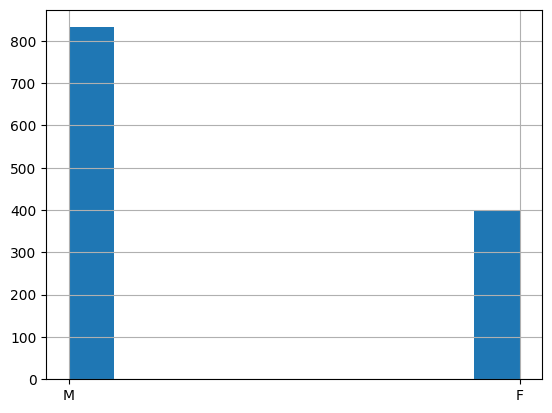

In [435]:
df7['Sexo'].hist()

In [436]:
df7['SEXO'].value_counts()

SEXO
1    832
0    401
Name: count, dtype: int64

In [437]:
df7.columns

Index(['ID_PACIENTE', 'Sexo', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP/INR',
       'TTPA - Paciente/Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'Ano nascimento', 'SEXO'],
      dtype='object')

## Entering TARGET (INFECTION)

In [438]:
df7['INFEC'] = np.nan

df7.head(3)

,ID_PACIENTE,Sexo,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,RDW,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento,SEXO,INFEC
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,...,14.6,143.0,0.83,0.91,86.0,94.9,10.0,1953.0,1,NaN
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,20.0,0.17,0.25,32.2,NaN,NaN,1.49,...,14.8,142.0,1.20,0.98,37.0,81.9,10.8,NaN,1,NaN
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,...,13.1,138.0,0.98,1.11,39.0,89.5,10.3,1965.0,1,NaN


In [439]:
# Spreadsheet import
df_pacientes_positivos = pd.read_excel('pacientes_positivos.xlsx', sheet_name='Sheet1')

# Column to list
lista_pacientes = df_pacientes_positivos["PACIENTE"].values.tolist()

df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 1

teste = df7[ df7["INFEC"] == 1]

teste["ID_PACIENTE"].nunique()

/tmp/ipykernel_7198/437129906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 1


168

In [440]:
# negative patients spreadsheet import
df_pacientes_negativos = pd.read_excel('pacientes_negativos.xlsx', sheet_name='Sheet1')

# column to list
lista_pacientes = df_pacientes_negativos[0].values.tolist()

df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 0

teste = df7[ df7["INFEC"] == 0]

teste["ID_PACIENTE"].nunique()

/tmp/ipykernel_7198/1875798870.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7["INFEC"].loc[ df7['ID_PACIENTE'].isin(lista_pacientes) ] = 0


1065

In [441]:
df7["INFEC"].value_counts()

INFEC
0.0    1065
1.0     168
Name: count, dtype: int64

In [442]:
df7["Infecção Hospitalar"] = " "

for index, row in df7.iterrows():
        if row['INFEC'] == 0:
            df7.loc[index,'Infecção Hospitalar'] = "negativo"
    
        else:
            df7.loc[index,'Infecção Hospitalar'] = "positivo"

df7.head(10)

,ID_PACIENTE,Sexo,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,Sódio,TP/INR,TTPA - Paciente/Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento,SEXO,INFEC,Infecção Hospitalar
0,004688799FD293C3ABE0A07209FD8B75,M,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,...,143.0,0.83,0.91,86.0,94.9,10.0,1953.0,1,0.0,negativo
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,M,24.0,20.0,0.17,0.25,32.2,NaN,NaN,1.49,...,142.0,1.20,0.98,37.0,81.9,10.8,NaN,1,0.0,negativo
2,009F0D6B3BA6C0E2D406585697D679EB,M,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,...,138.0,0.98,1.11,39.0,89.5,10.3,1965.0,1,0.0,negativo
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,M,22.0,20.0,0.08,0.12,34.5,93.0,1.18,1.78,...,133.0,0.98,1.13,155.0,103.6,9.9,1933.0,1,0.0,negativo
4,010AF0C3418C765CDA28B5957210A819,F,162.0,20.0,0.12,0.15,33.7,51.0,1.18,0.82,...,137.0,1.00,1.13,23.0,88.2,10.1,1955.0,0,0.0,negativo
5,013AEBC1C56D166839C2D593971B8073,F,139.0,10.0,0.26,0.17,31.8,NaN,1.17,1.87,...,147.0,1.60,0.83,99.0,87.4,11.8,1966.0,0,0.0,negativo
6,0183BA4D9368936BAD131398B55CDDC3,M,115.0,10.0,0.19,0.14,32.8,106.0,1.24,1.34,...,140.0,1.00,0.95,57.0,84.7,11.2,1953.0,1,0.0,negativo
7,01A30B6624DDB49F16CA4311CC37D65F,M,25.0,10.0,0.13,0.11,33.3,60.0,NaN,0.98,...,142.0,NaN,NaN,22.0,83.0,9.4,1984.0,1,0.0,negativo
8,02367C393B8487123744A46CFBB91A28,M,13.0,10.0,0.14,0.27,32.0,72.0,1.25,0.77,...,137.0,1.10,1.11,28.0,99.1,8.8,1948.0,1,0.0,negativo
9,023B1D40B2A154BBCC3A37EE25AD890D,M,NaN,10.0,0.31,0.22,34.2,NaN,NaN,1.69,...,NaN,1.20,1.13,90.0,89.4,8.9,1938.0,1,0.0,negativo


<Axes: >

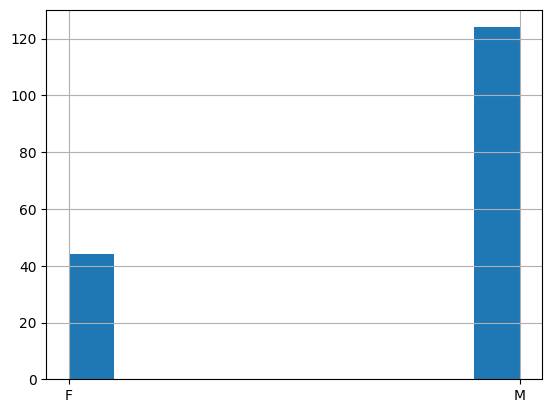

In [443]:
df7_infec = df7[ df7["INFEC"] == 1]
df7_infec["Sexo"].hist()

<Axes: >

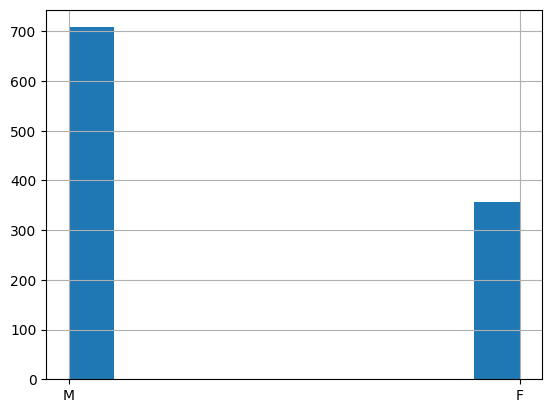

In [444]:
df7_infec = df7[ df7["INFEC"] == 0]
df7_infec["Sexo"].hist()

In [445]:
df7 = df7.drop(columns=["Sexo"])

In [446]:
def print_boxplot(atributo):
  plt.title(atributo, size=16)
  plt.gcf().set_size_inches(15, 3) # alterar tamanho
  #plt.xticks(range(0, 100, 10)) # mudar escala do eixo X
  
  #plt.xlabel( fontsize = 18) 
  #plt.ylabel( fontsize = 18)
  #plt.legend( fontsize = 18)
  plt.tick_params(labelsize=20) 
  
  ax = sns.boxplot(x=atributo, 
                   y="Infecção Hospitalar",
                   hue="Infecção Hospitalar",
                   data=df7,
                   palette="Set2")
  plt.savefig("Plots/"+atributo+'.png')
  plt.show()
  print("\n")

In [447]:
df7.columns

Index(['ID_PACIENTE', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP/INR',
       'TTPA - Paciente/Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'Ano nascimento', 'SEXO', 'INFEC', 'Infecção Hospitalar'],
      dtype='object')

In [448]:
df7.columns = ['ID_PACIENTE', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'Ano nascimento', 'SEXO', 'INFEC', 'Infecção Hospitalar']

In [449]:
df7.columns[1:-2]

Index(['ALT (TGP)', 'Basófilos', 'Bilirrubina Direta', 'Bilirrubina Indireta',
       'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina', 'DHL',
       'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina', 'Fibrinogenio',
       'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM', 'HCO3 venoso',
       'Hemoglobina', 'Leucócitos', 'Leucócitos, urina', 'Linfócitos',
       'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas', 'Potássio',
       'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'Ano nascimento', 'SEXO'],
      dtype='object')

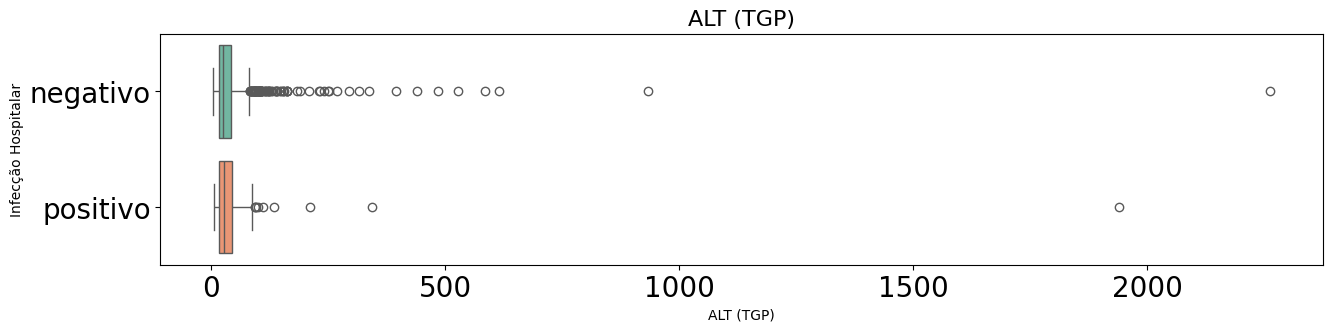

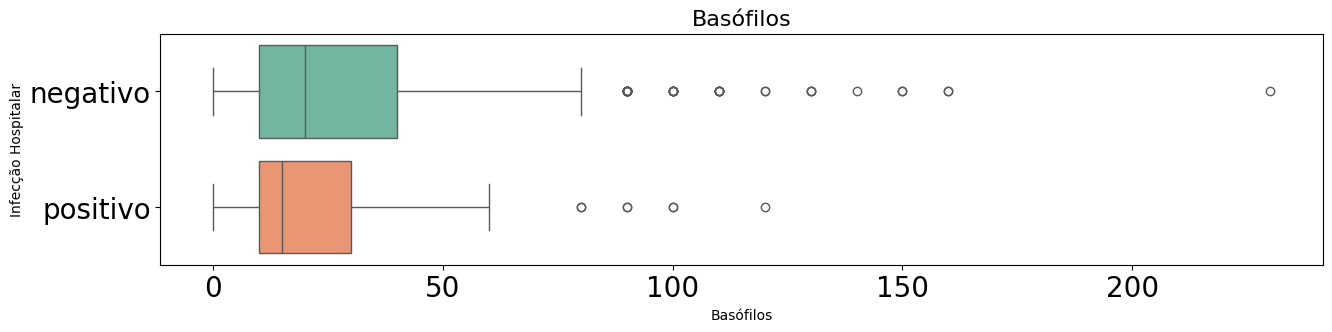

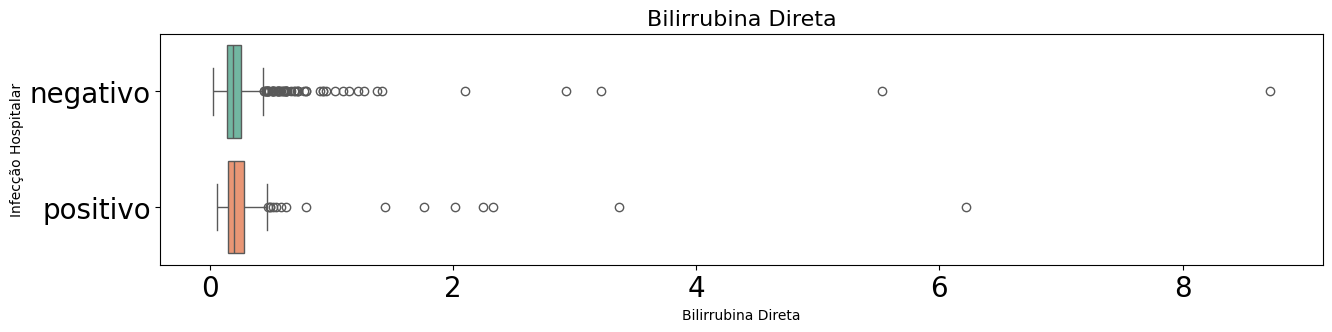

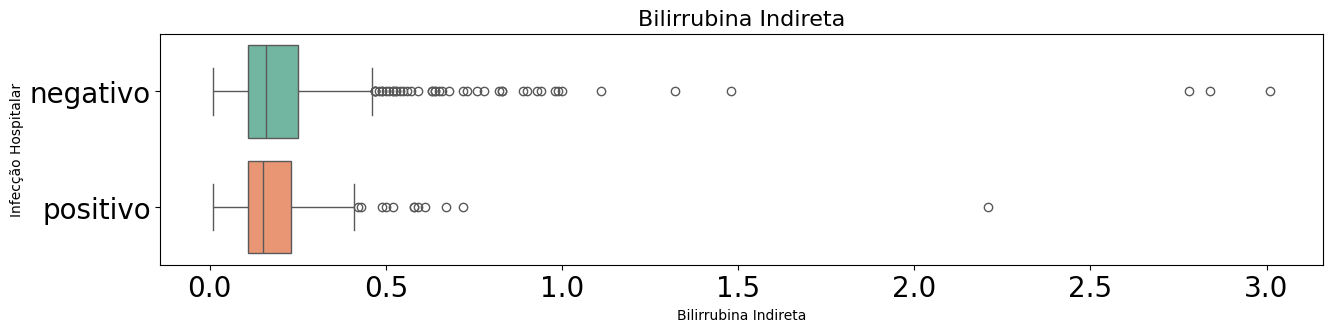

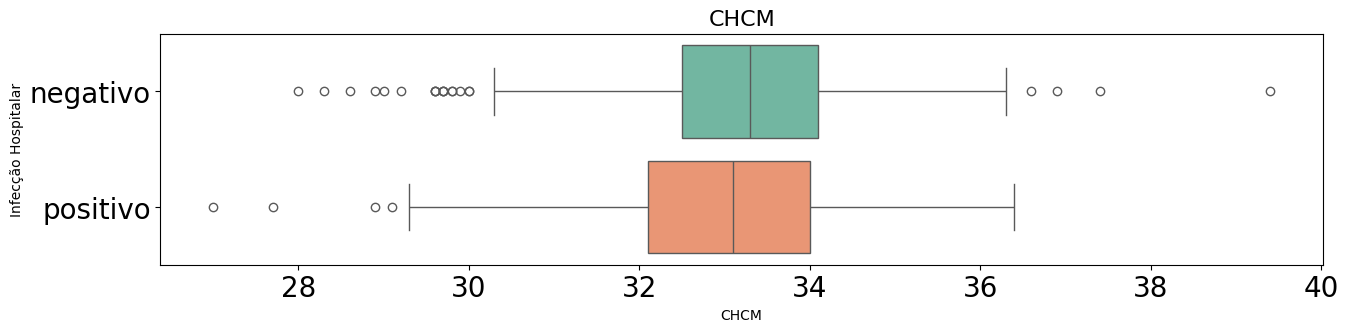

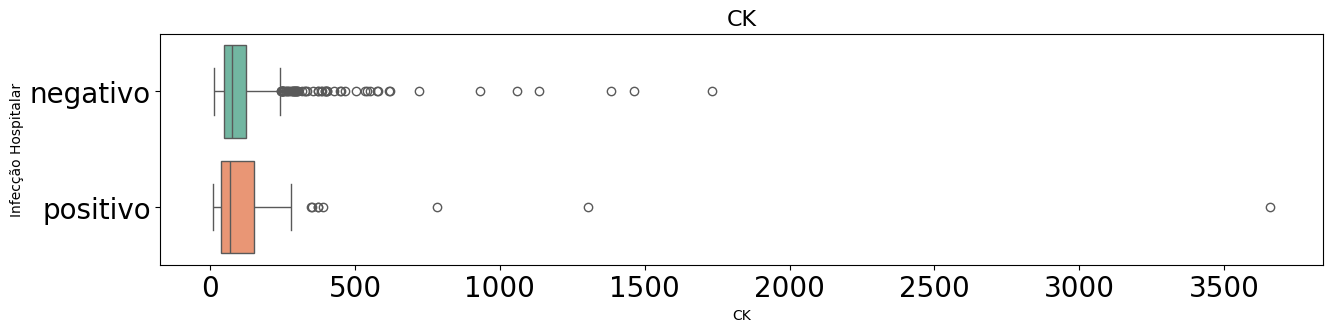

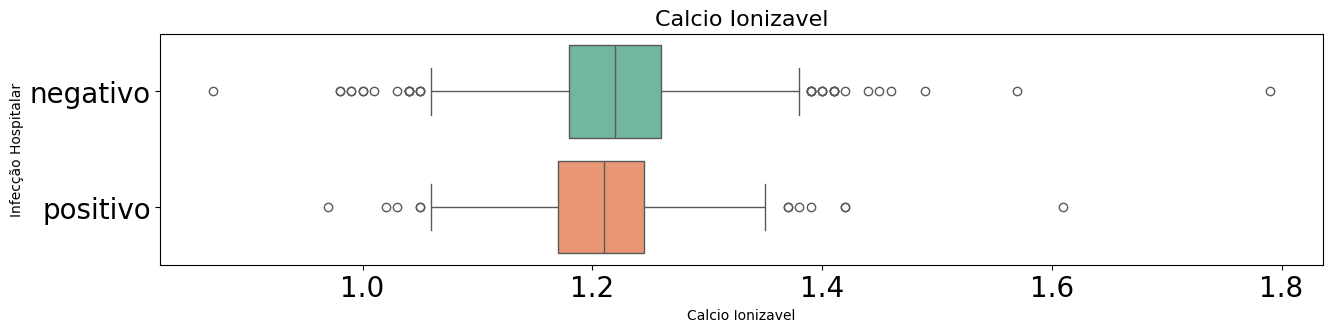

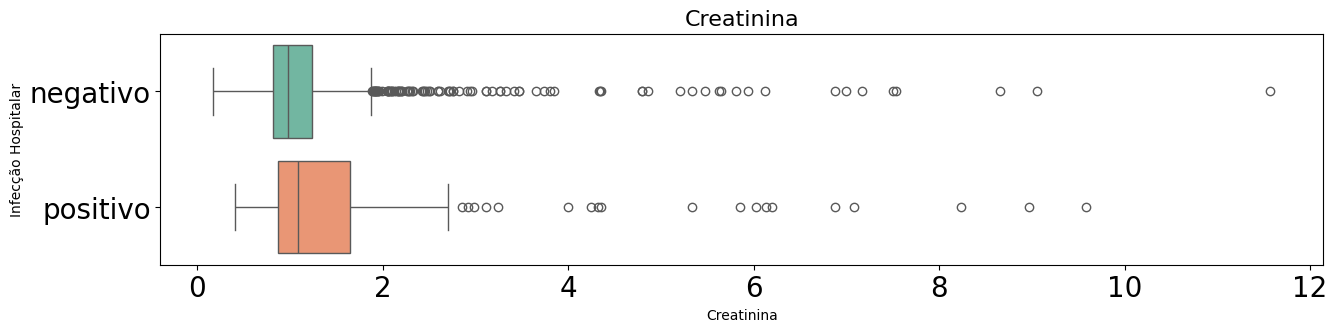

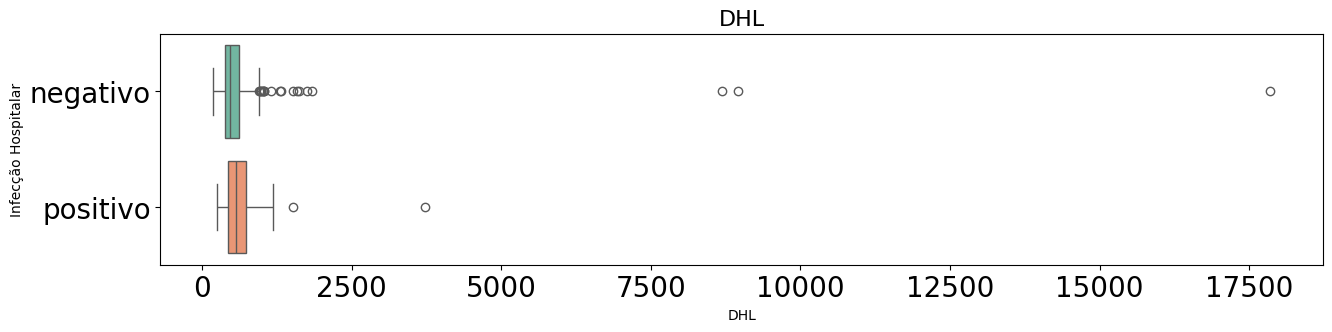

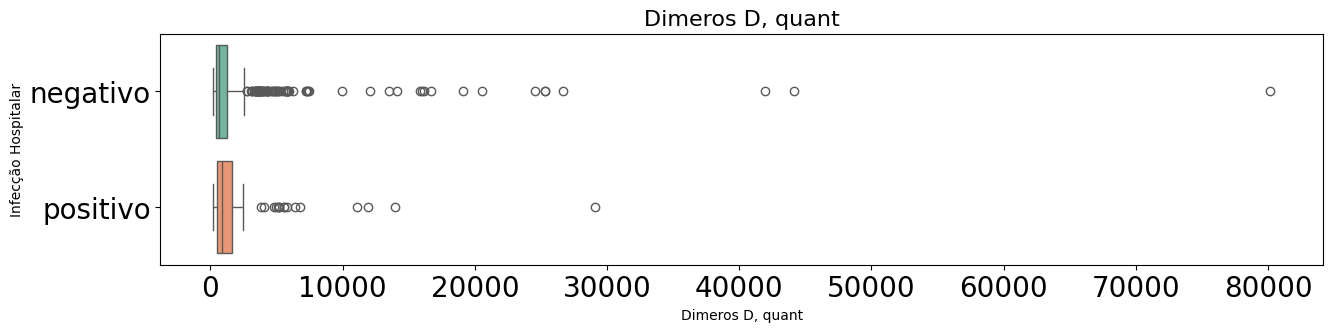

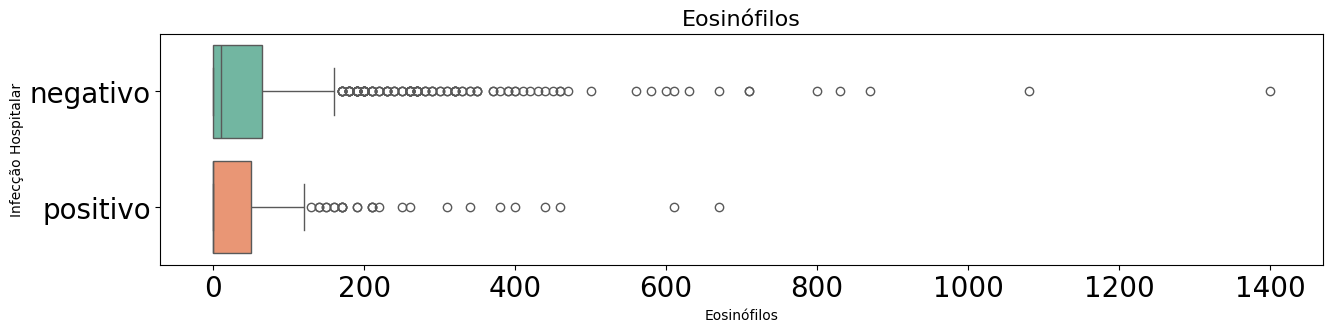

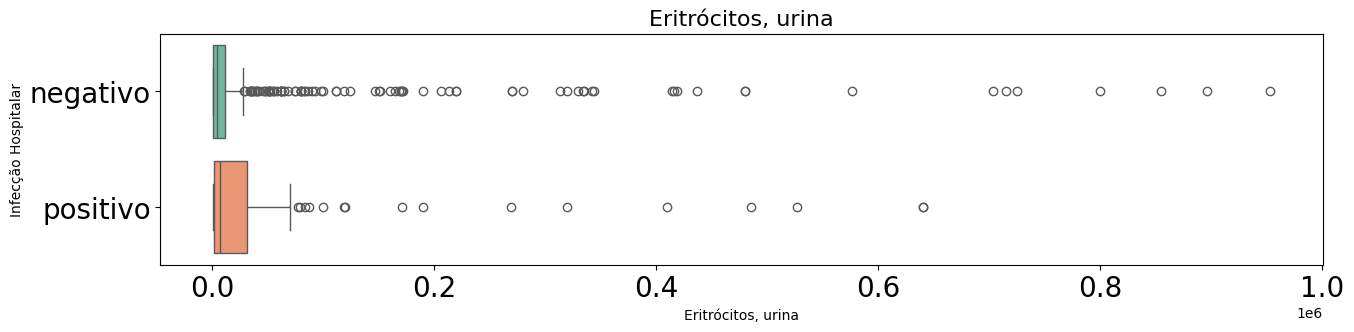

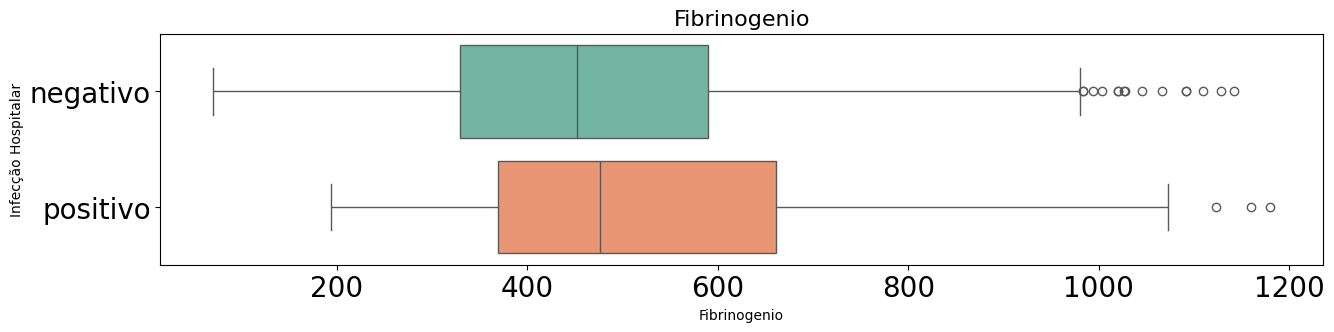

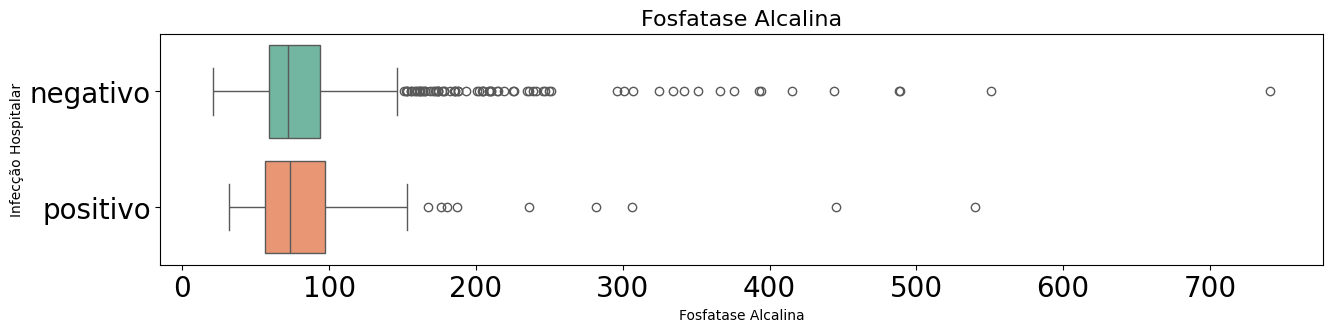

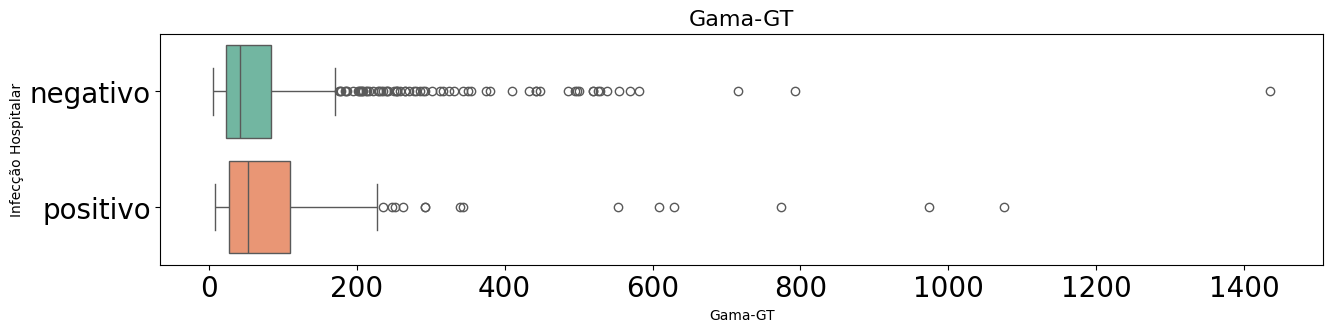

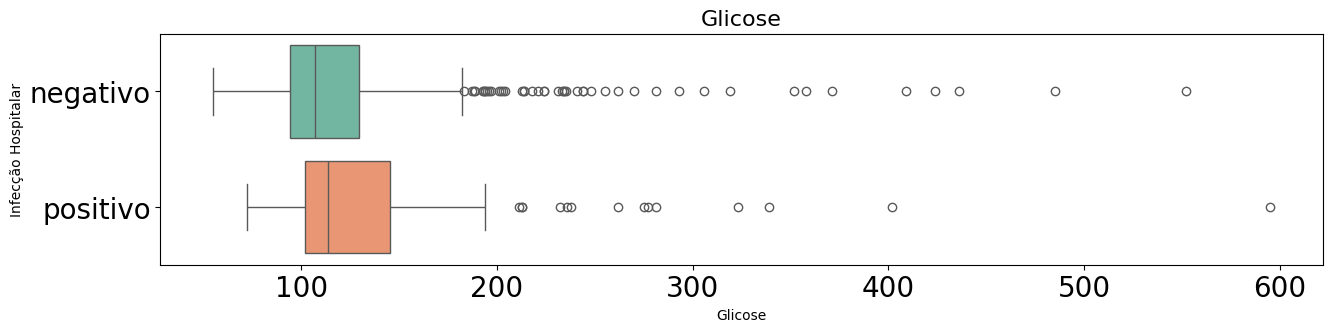

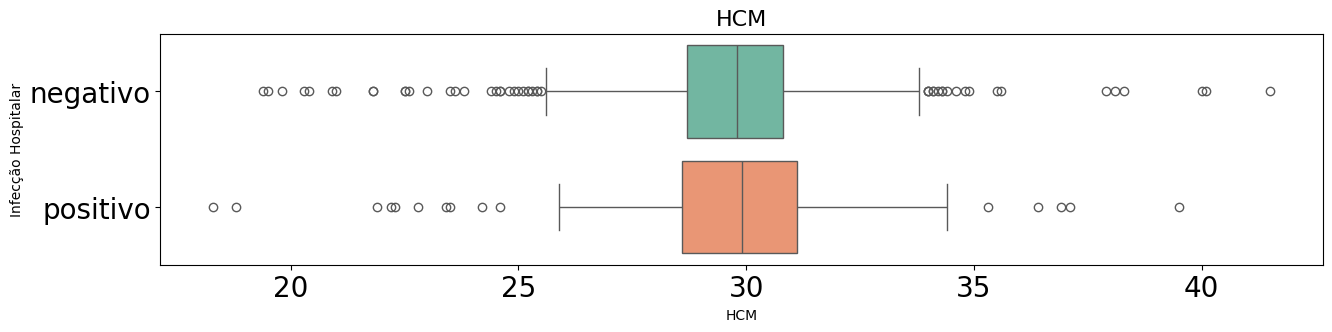

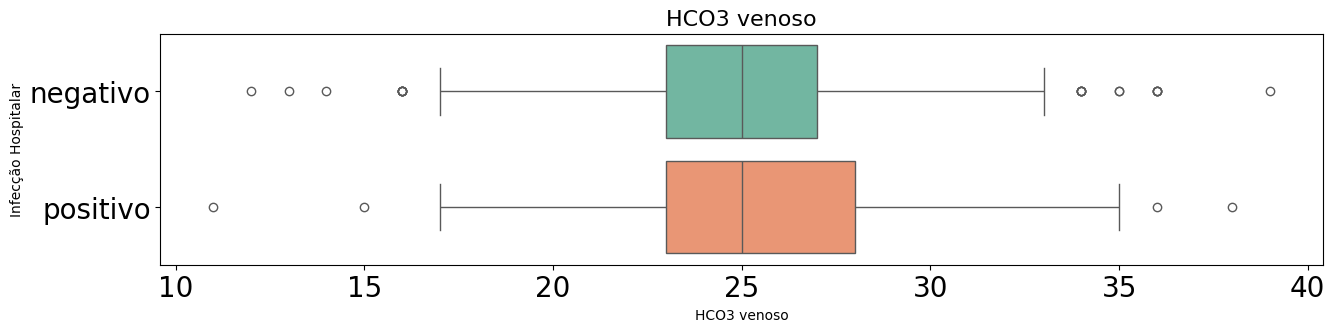

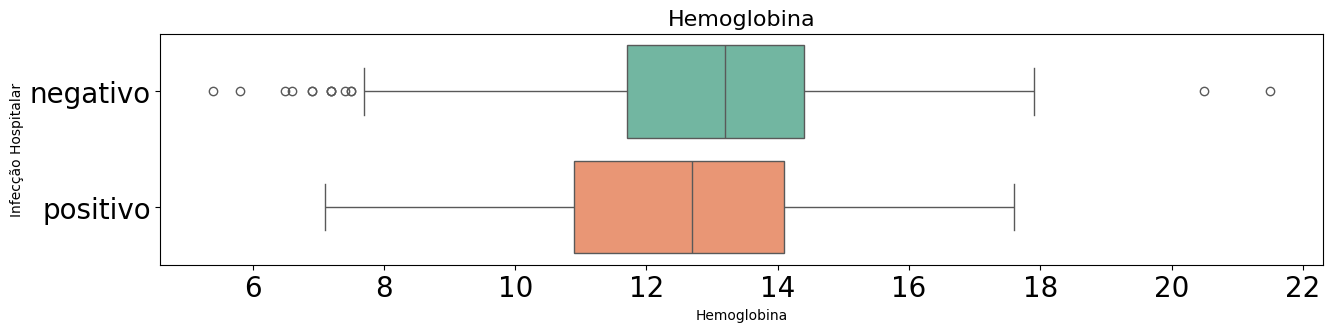

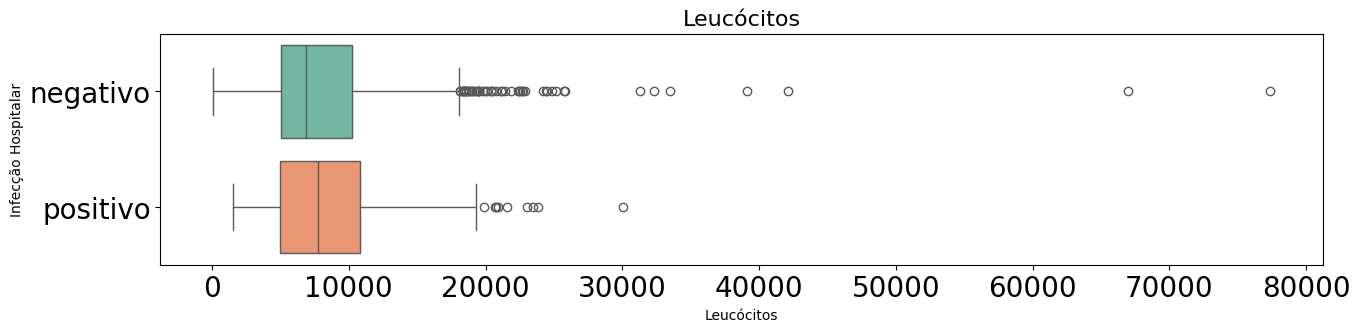

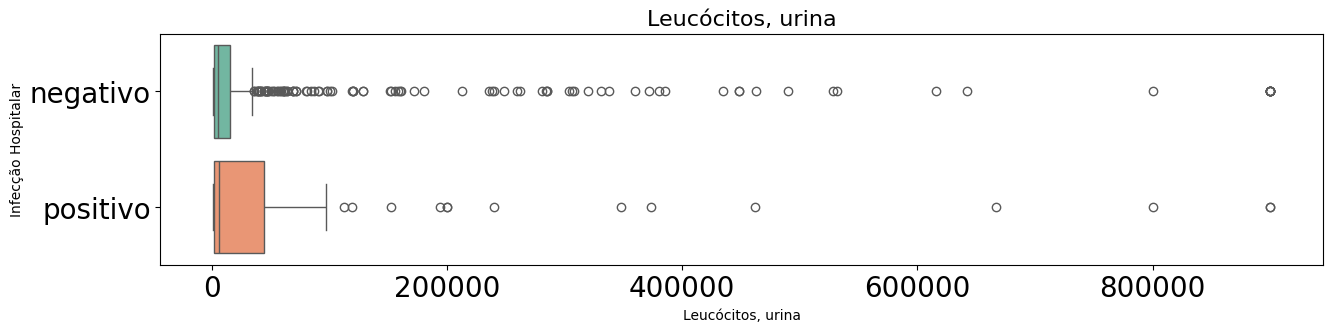

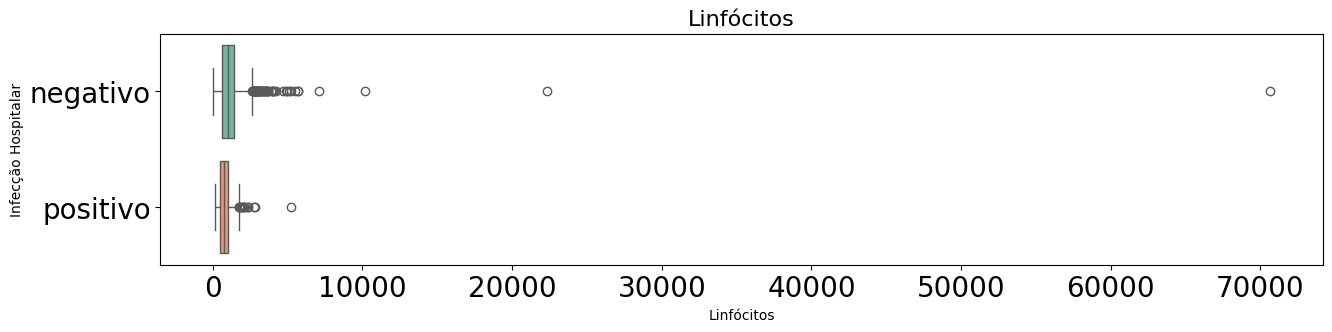

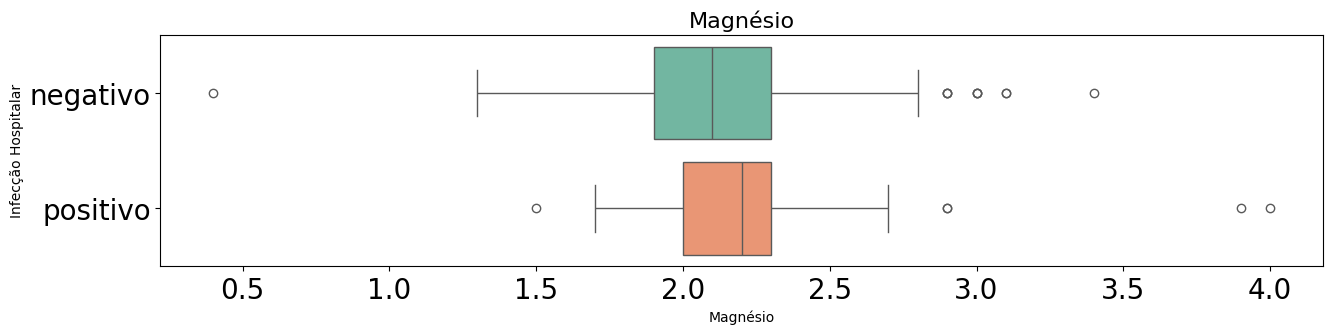

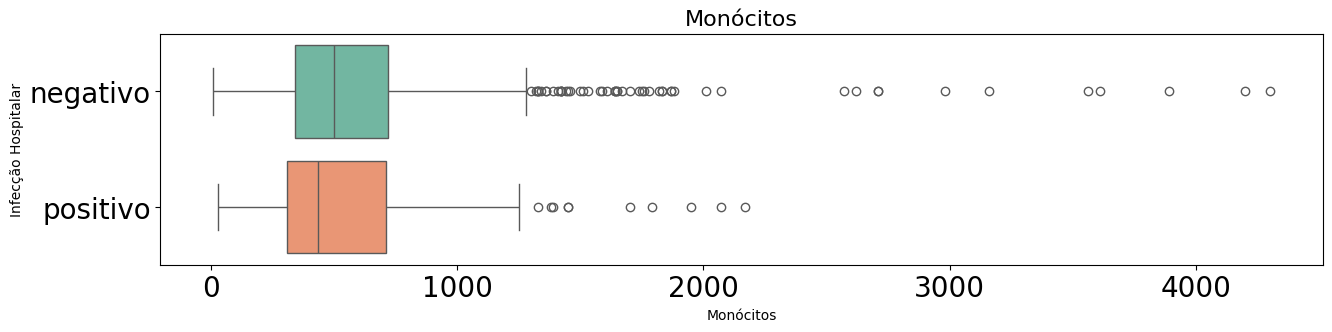

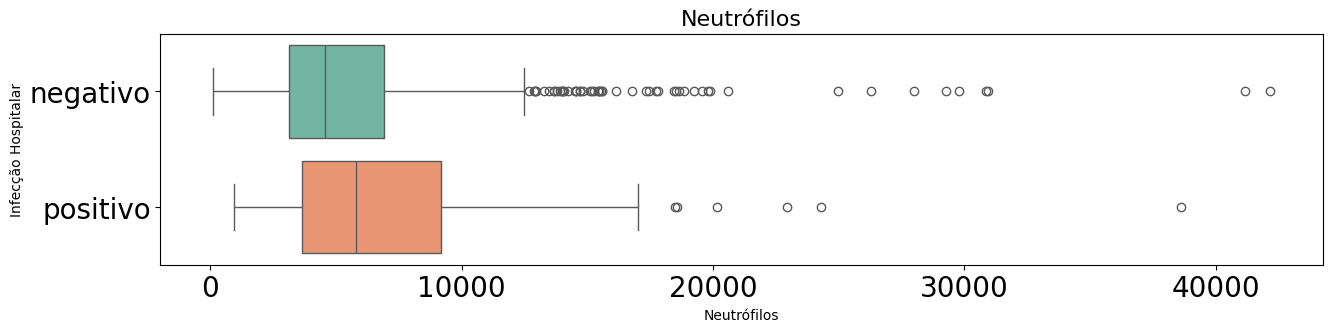

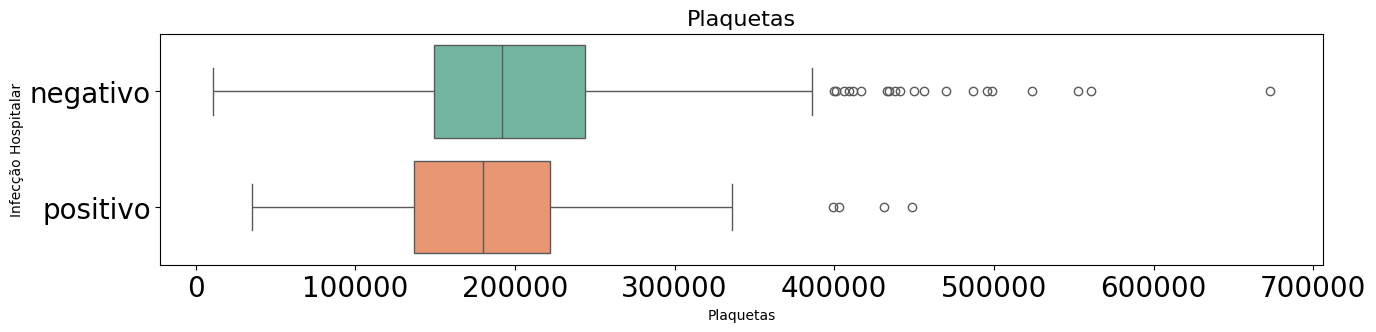

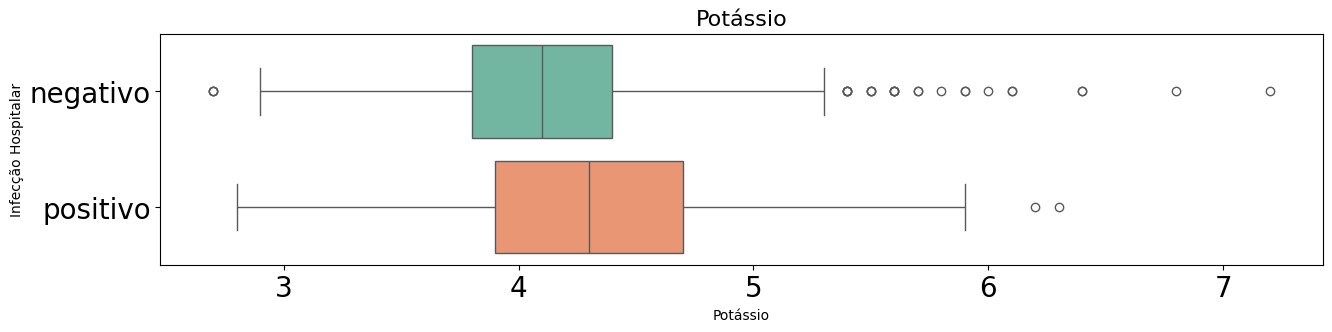

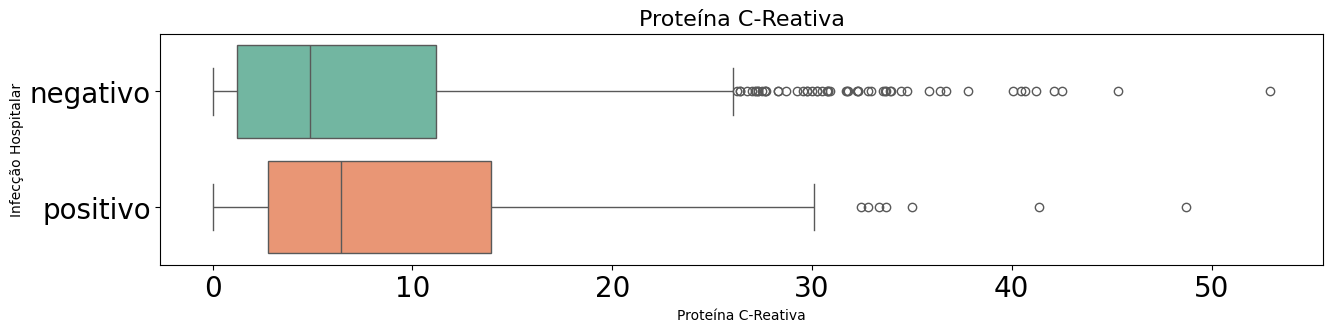

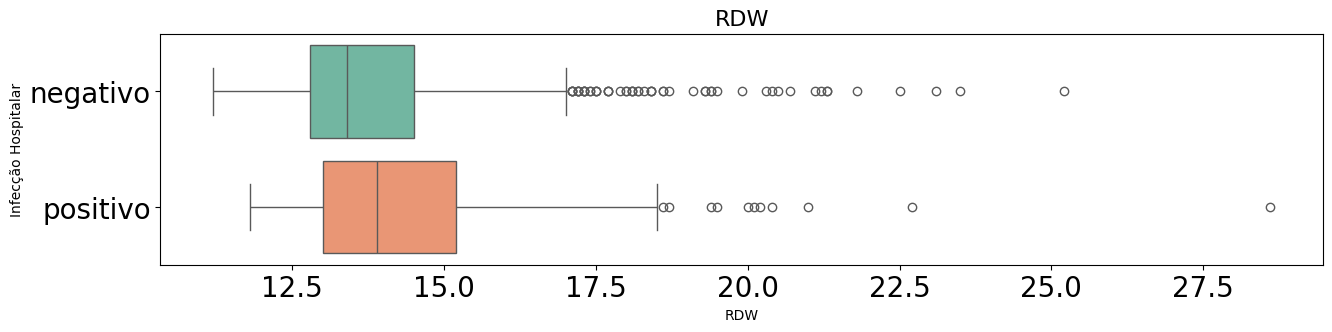

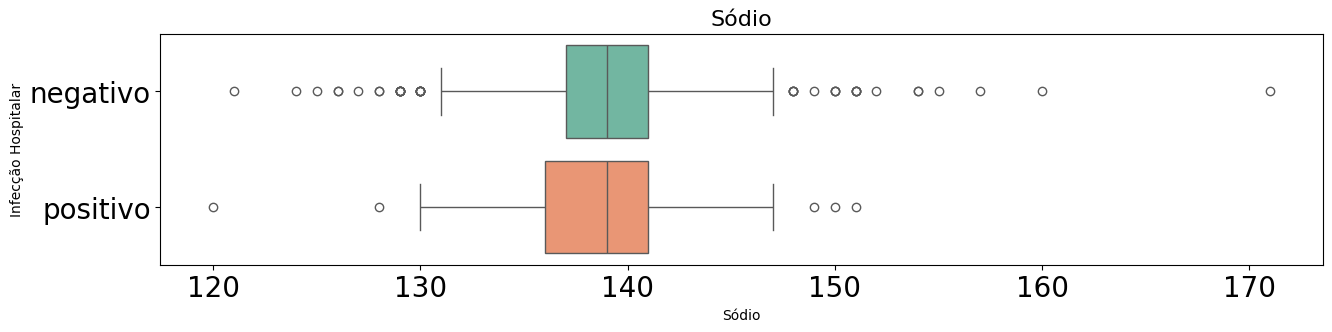

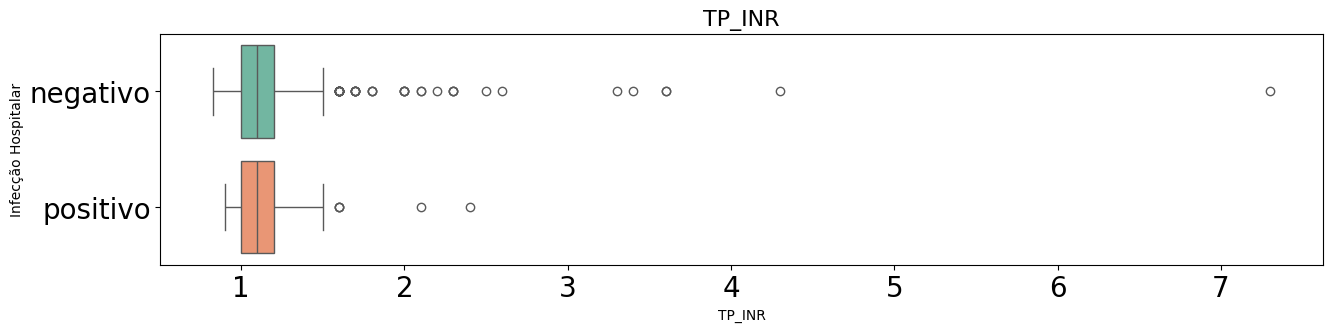

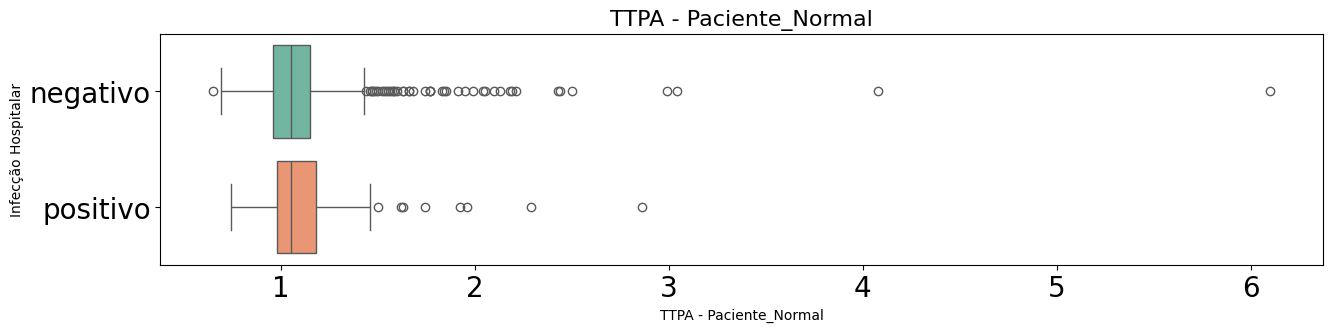

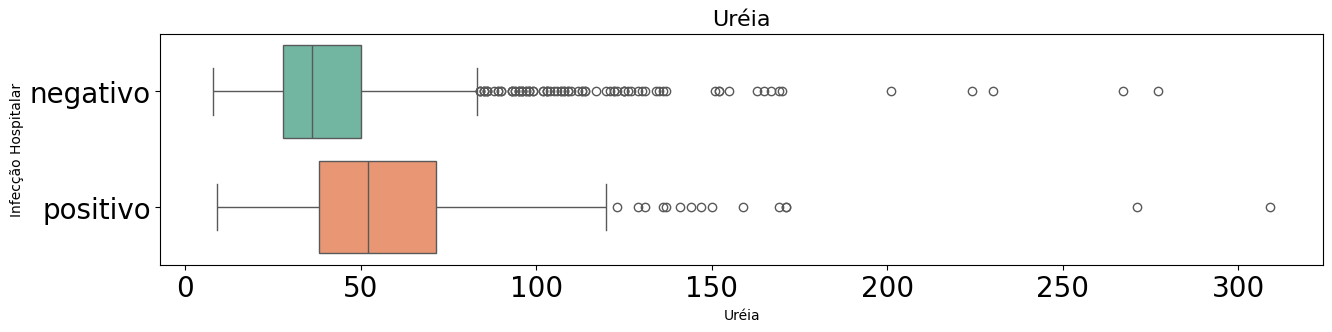

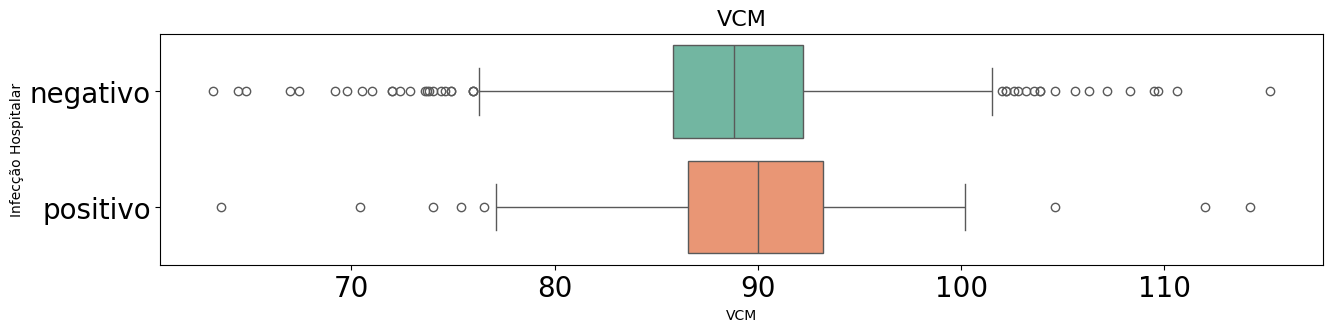

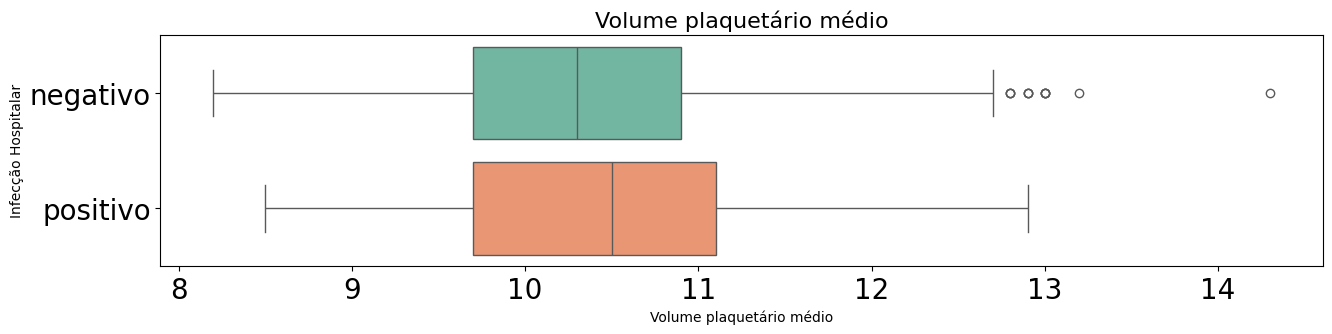

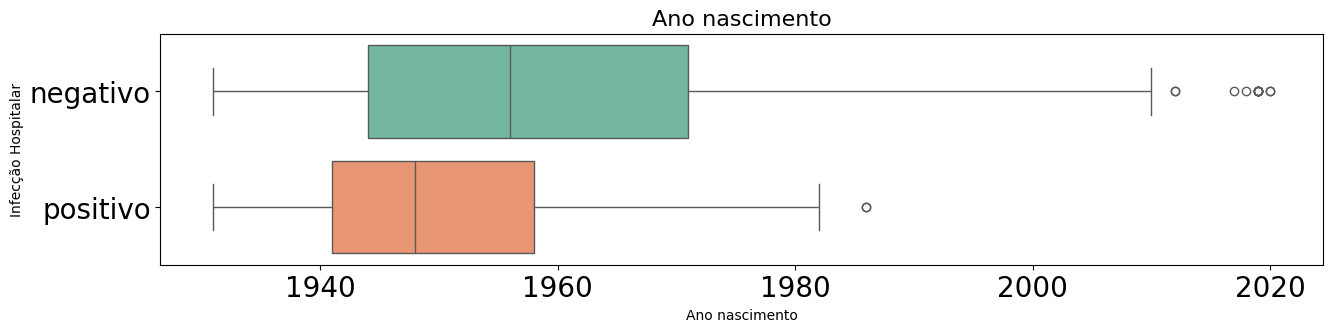

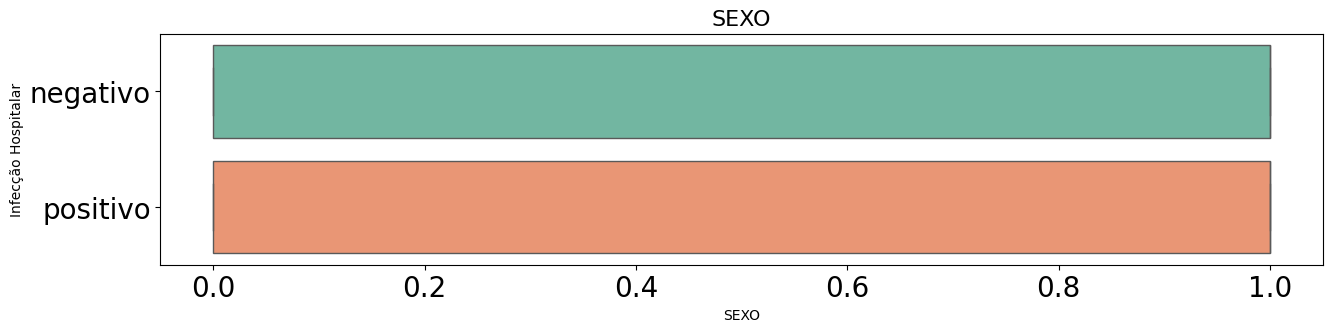

In [450]:
colunas = df7.columns[1:-2]

for i in colunas:
  print_boxplot(i)

In [451]:
df7

,ID_PACIENTE,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,DHL,...,Sódio,TP_INR,TTPA - Paciente_Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento,SEXO,INFEC,Infecção Hospitalar
0,004688799FD293C3ABE0A07209FD8B75,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,489.0,...,143.0,0.83,0.91,86.0,94.9,10.0,1953.0,1,0.0,negativo
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,24.0,20.0,0.17,0.25,32.2,NaN,NaN,1.49,NaN,...,142.0,1.20,0.98,37.0,81.9,10.8,NaN,1,0.0,negativo
2,009F0D6B3BA6C0E2D406585697D679EB,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,716.0,...,138.0,0.98,1.11,39.0,89.5,10.3,1965.0,1,0.0,negativo
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,22.0,20.0,0.08,0.12,34.5,93.0,1.18,1.78,721.0,...,133.0,0.98,1.13,155.0,103.6,9.9,1933.0,1,0.0,negativo
4,010AF0C3418C765CDA28B5957210A819,162.0,20.0,0.12,0.15,33.7,51.0,1.18,0.82,654.0,...,137.0,1.00,1.13,23.0,88.2,10.1,1955.0,0,0.0,negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,NaN,10.0,NaN,NaN,34.6,NaN,1.15,0.54,NaN,...,137.0,1.00,0.90,59.0,90.3,11.3,1962.0,1,1.0,positivo
1229,FECC5CE1CFE3BCE881F29C2333527135,10.0,30.0,NaN,NaN,35.3,NaN,NaN,0.86,NaN,...,138.0,NaN,NaN,25.0,92.5,10.4,1980.0,0,0.0,negativo
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,15.0,20.0,0.17,0.18,32.9,138.0,1.22,0.75,440.0,...,139.0,1.30,1.05,33.0,95.7,10.8,1943.0,0,0.0,negativo
1231,FF4B2EED093AE641B9328FDB293C4116,35.0,10.0,0.16,0.25,34.2,NaN,1.28,1.15,274.0,...,137.0,1.00,1.06,28.0,83.7,10.6,1969.0,1,0.0,negativo


In [452]:
df7_1 = df7.drop(columns=["Infecção Hospitalar"])

In [470]:
df7_1

,ID_PACIENTE,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,DHL,...,RDW,Sódio,TP_INR,TTPA - Paciente_Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento,SEXO,INFEC
0,004688799FD293C3ABE0A07209FD8B75,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,489.0,...,14.6,143.0,0.83,0.91,86.0,94.9,10.0,1953.0,1,0.0
1,0047AF5116BC8AC8EFE6BBB98DA14DFA,24.0,20.0,0.17,0.25,32.2,NaN,NaN,1.49,NaN,...,14.8,142.0,1.20,0.98,37.0,81.9,10.8,NaN,1,0.0
2,009F0D6B3BA6C0E2D406585697D679EB,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,716.0,...,13.1,138.0,0.98,1.11,39.0,89.5,10.3,1965.0,1,0.0
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,22.0,20.0,0.08,0.12,34.5,93.0,1.18,1.78,721.0,...,13.2,133.0,0.98,1.13,155.0,103.6,9.9,1933.0,1,0.0
4,010AF0C3418C765CDA28B5957210A819,162.0,20.0,0.12,0.15,33.7,51.0,1.18,0.82,654.0,...,14.2,137.0,1.00,1.13,23.0,88.2,10.1,1955.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,NaN,10.0,NaN,NaN,34.6,NaN,1.15,0.54,NaN,...,12.5,137.0,1.00,0.90,59.0,90.3,11.3,1962.0,1,1.0
1229,FECC5CE1CFE3BCE881F29C2333527135,10.0,30.0,NaN,NaN,35.3,NaN,NaN,0.86,NaN,...,12.9,138.0,NaN,NaN,25.0,92.5,10.4,1980.0,0,0.0
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,15.0,20.0,0.17,0.18,32.9,138.0,1.22,0.75,440.0,...,14.8,139.0,1.30,1.05,33.0,95.7,10.8,1943.0,0,0.0
1231,FF4B2EED093AE641B9328FDB293C4116,35.0,10.0,0.16,0.25,34.2,NaN,1.28,1.15,274.0,...,12.8,137.0,1.00,1.06,28.0,83.7,10.6,1969.0,1,0.0


In [471]:
# Analyze Ano nascimento == np.nan
df_2 = df7_1[df7_1["Ano nascimento"].isna()]

# Analyze target 
df_2["INFEC"].value_counts()

INFEC
0.0    80
1.0    10
Name: count, dtype: int64

In [473]:
# delete only year birth == np.nan and infec == 0

# conditions
#filter1 = df7_1['Ano nascimento'].isna()
#filter2 = df7_1['INFEC'] == 0

# Filtering
#df_filtrado = df7_1.query("filter1 & filter2")
df_filtrado = df7_1.query("`Ano nascimento`.isna() & `INFEC` == 0")

# drop lines
df7_1.drop(df_filtrado.index, axis=0, inplace=True)

df7_1


,ID_PACIENTE,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,DHL,...,RDW,Sódio,TP_INR,TTPA - Paciente_Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento,SEXO,INFEC
0,004688799FD293C3ABE0A07209FD8B75,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,489.0,...,14.6,143.0,0.83,0.91,86.0,94.9,10.0,1953.0,1,0.0
2,009F0D6B3BA6C0E2D406585697D679EB,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,716.0,...,13.1,138.0,0.98,1.11,39.0,89.5,10.3,1965.0,1,0.0
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,22.0,20.0,0.08,0.12,34.5,93.0,1.18,1.78,721.0,...,13.2,133.0,0.98,1.13,155.0,103.6,9.9,1933.0,1,0.0
4,010AF0C3418C765CDA28B5957210A819,162.0,20.0,0.12,0.15,33.7,51.0,1.18,0.82,654.0,...,14.2,137.0,1.00,1.13,23.0,88.2,10.1,1955.0,0,0.0
5,013AEBC1C56D166839C2D593971B8073,139.0,10.0,0.26,0.17,31.8,NaN,1.17,1.87,NaN,...,13.2,147.0,1.60,0.83,99.0,87.4,11.8,1966.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,FEC09496E67CD8A4DE225245AF35799C,NaN,10.0,NaN,NaN,34.6,NaN,1.15,0.54,NaN,...,12.5,137.0,1.00,0.90,59.0,90.3,11.3,1962.0,1,1.0
1229,FECC5CE1CFE3BCE881F29C2333527135,10.0,30.0,NaN,NaN,35.3,NaN,NaN,0.86,NaN,...,12.9,138.0,NaN,NaN,25.0,92.5,10.4,1980.0,0,0.0
1230,FF19A1D8C1EB3A7A73541F3443B4FA00,15.0,20.0,0.17,0.18,32.9,138.0,1.22,0.75,440.0,...,14.8,139.0,1.30,1.05,33.0,95.7,10.8,1943.0,0,0.0
1231,FF4B2EED093AE641B9328FDB293C4116,35.0,10.0,0.16,0.25,34.2,NaN,1.28,1.15,274.0,...,12.8,137.0,1.00,1.06,28.0,83.7,10.6,1969.0,1,0.0


In [474]:
# Analyze Ano nascimento == np.nan
df_2 = df7_1[df7_1["Ano nascimento"].isna()]

# Analyze target 
df_2["INFEC"].value_counts()

INFEC
1.0    10
Name: count, dtype: int64

In [475]:
df7_1.to_csv("dataset.csv")

In [ ]:
# The end

# 8.0 **MACHINE LEARNING** (ONLY primary tests)

In [476]:
df8 = df7_1.copy(deep=True)

print(df8.shape)

df8.head(3)

(1153, 39)


,ID_PACIENTE,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,DHL,...,RDW,Sódio,TP_INR,TTPA - Paciente_Normal,Uréia,VCM,Volume plaquetário médio,Ano nascimento,SEXO,INFEC
0,004688799FD293C3ABE0A07209FD8B75,16.0,30.0,0.20,0.35,32.1,43.0,1.21,1.95,489.0,...,14.6,143.0,0.83,0.91,86.0,94.9,10.0,1953.0,1,0.0
2,009F0D6B3BA6C0E2D406585697D679EB,25.0,20.0,0.19,0.24,34.9,153.0,1.24,1.22,716.0,...,13.1,138.0,0.98,1.11,39.0,89.5,10.3,1965.0,1,0.0
3,00DCB2411CFD2F3C9FB4CD35C3AACCA1,22.0,20.0,0.08,0.12,34.5,93.0,1.18,1.78,721.0,...,13.2,133.0,0.98,1.13,155.0,103.6,9.9,1933.0,1,0.0


In [477]:
#algorithms
algorithms = {
    "SVM": (SVC(probability= True), {"C": [1, 10], "kernel": ("linear", "rbf"), "gamma": ('scale', 'auto')}),
    "RF" : (RandomForestClassifier(random_state=0), {"n_estimators": [100,200,500], "max_depth": [4,6,10],"max_features":("auto", "sqrt")}),
    "GB" : (GradientBoostingClassifier(random_state=0), {"n_estimators": [100,200,500],  'learning_rate': [0.05, 0.1], "max_depth": [4,6,10]})
}

In [478]:
#dataset

hosp1 = df8

data = {
    "hosp1": ( (hosp1.drop(columns=["INFEC", "ID_PACIENTE"])), hosp1.INFEC)
}

In [479]:
ini = time.time()

#3 folds to choose the best hyperparameters
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=20) 

#choose of the best hyperparameters through balanced accuracy
perf = balanced_accuracy_score

#10-fold cross validation 
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=20) 

#define Standard Scaler to standardize the features
prep = StandardScaler()

#undersampling the majority class when classes are umbalanced
under = RandomUnderSampler(sampling_strategy='majority', random_state = 0)

#impute missing values with the mean of the 3 nearest neighbours
imputer = KNNImputer(n_neighbors=3, weights = 'distance')

#for each dataset
for name, (X,y) in data.items(): 

    #store the recall of each algorithm 
    score = {}
    for algorithm in algorithms.keys():
        score[algorithm] = []

    #store the auc for each algorithm
    auc_score = {}
    for algorithm in algorithms.keys():
        auc_score[algorithm] = []
    
    #for each algorithm and its respective search space
    for algorithm, (clf, parameters) in algorithms.items():
        
        #define a grid search for the best hyperparameters
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=(make_scorer(perf)))

        for train, test in kf.split(X, y):
            
            #split train and test 
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
            
            #check if the majoritary class is 1.5 times larger than the other
            y_ = pd.DataFrame.from_dict(y)
            if (((y_[y_.INFEC == 1].shape[0])*1.5) < (y_[y_.INFEC == 0].shape[0])):
                
                #vectors to store y_pred e y_true
                y_pred = [] 
                y_true = [] 

                #undersampling of the majority class
                X_train, y_train = under.fit_resample(X_train, y_train)

                #impute missing values with the mean of the 3 nearest neighbors
                imputer.fit(X_train)
                X_train = imputer.transform(X_train)
                X_test = imputer.transform(X_test)        

                #standardize the features                
                prep.fit(X_train)

                #search for the best hyperparameters
                best.fit(prep.transform(X_train), y_train)

                #store the results
                y_pred = [*y_pred, *(best.predict(prep.transform(X_test)))] 
                y_true =  [*y_true, *y_test] 

                #calculate the recall
                score[algorithm].append(recall_score(y_true, y_pred, labels = [0,1], average = None))

                #calculate the area under roc curve
                aucscore = roc_auc_score(y_test, (best.predict_proba(prep.transform(X_test)))[:, 1])
                auc_score[algorithm].append(aucscore)

           
            #if classes are not umbalanced
            else:
                #vectors to store y_pred e y_true
                y_pred = [] 
                y_true = [] 

                #impute missing values with the mean of the 3 nearest neighbors
                imputer.fit(X_train)
                X_train = imputer.transform(X_train)
                X_test = imputer.transform(X_test)        

                #standardize the features                
                prep.fit(X_train)

                #search for the best hyperparameters
                best.fit(prep.transform(X_train), y_train)

                #store the results
                y_pred = [*y_pred, *(best.predict(prep.transform(X_test)))] 
                y_true =  [*y_true, *y_test] 

                #calculate the recall
                score[algorithm].append(recall_score(y_true, y_pred, labels = [0,1], average = None))

                #calculate the area under roc curve
                aucscore = roc_auc_score(y_test, (best.predict_proba(prep.transform(X_test)))[:, 1])
                auc_score[algorithm].append(aucscore)
    
    #write a csv with auc values
    auc_score = pd.DataFrame.from_dict(auc_score)  
    auc_score.to_csv(name + '_auc.csv')
    
    #write a csv with the recall of class '0' - specificity 
    #and another csv with the recall of class '1' - sensitivity
    recall_svm = pd.DataFrame(np.vstack(score['SVM']))
    recall_gb = pd.DataFrame(np.vstack(score['GB']))
    recall_rf = pd.DataFrame(np.vstack(score['RF']))

    esp = pd.concat([recall_svm[[0]], recall_rf[[0]], recall_gb[[0]]], axis=1)
    sen = pd.concat([recall_svm[[1]], recall_rf[[1]], recall_gb[[1]]], axis=1)

    esp.columns = ['SVM', 'RF', 'GB']
    sen.columns = ['SVM', 'RF', 'GB']

    esp.to_csv(name + '_spe.csv')
    sen.to_csv(name + '_sen.csv')  

fim = time.time()
print('\n')
print('Tempo de execução', round((fim - ini)/60, 4), 'minutos')

/home/filipe/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/filipe/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/filipe/.local/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/filipe/.local/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/home/filipe/.local



Tempo de execução 10.306 minutos


In [480]:
#hosp1
auc = pd.read_csv('hosp1_auc.csv')

# recall
sen = pd.read_csv('hosp1_sen.csv')
spe = pd.read_csv('hosp1_spe.csv')

column_names = ["svm", "gb", "rf"]

df = pd.DataFrame(columns = column_names)
df.loc['auc'] = [auc['SVM'].mean(), auc['GB'].mean(), auc['RF'].mean()]
df.loc['positivo'] = [sen['SVM'].mean(), sen['GB'].mean(), sen['RF'].mean()]
df.loc['negativo'] = [spe['SVM'].mean(), spe['GB'].mean(), spe['RF'].mean()]

print("Média")
df = df.round(decimals=3)
df

Média


,svm,gb,rf
auc,0.696,0.663,0.706
positivo,0.695,0.642,0.635
negativo,0.618,0.623,0.639



svm	gb	rf

auc	0.681	0.653	0.689

positivo	0.665	0.577	0.607

negativo	0.612	0.599	0.619

In [481]:
df = pd.DataFrame(columns = column_names)
df.loc['auc'] = [auc['SVM'].std(), auc['GB'].std(), auc['RF'].std()]
df.loc['positivo'] = [sen['SVM'].std(), sen['GB'].std(), sen['RF'].std()]
df.loc['negativo'] = [spe['SVM'].std(), spe['GB'].std(), spe['RF'].std()]

print("Desvio padrão")
df = df.round(decimals=3)
df

Desvio padrão


,svm,gb,rf
auc,0.070,0.058,0.039
positivo,0.143,0.111,0.108
negativo,0.081,0.073,0.063


# SHAP graphic to RF algorithm


In [147]:
import shap

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

from sklearn.metrics import balanced_accuracy_score, make_scorer, roc_auc_score, recall_score

from imblearn.under_sampling import RandomUnderSampler

from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt

/home/filipe/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [148]:
#algorithms
algorithms = {
    "RF" : (RandomForestClassifier(random_state=0), {"n_estimators": [100,200,500], "max_depth": [4,6,10],"max_features":("auto", "sqrt")})
}

In [149]:
#dataset

hosp1 = df7.copy(deep=True)

data = {
    "hosp1": ( (hosp1.drop(columns=["INFEC", "Infecção Hospitalar", "ID_PACIENTE"])), hosp1.INFEC)
}

In [150]:
#3 folds to choose the best hyperparameters
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) 

#choose of the best hyperparameters through balanced accuracy
perf = balanced_accuracy_score

#undersampling the majority class when classes are umbalanced
under = RandomUnderSampler(sampling_strategy='majority', random_state = 0)

#impute missing values with the mean of the 3 nearest neighbours
imputer = KNNImputer(n_neighbors=3, weights = 'distance')

#standardize the features
prep = StandardScaler()

shap.initjs()

#for each dataset
for name, (X,y) in data.items(): 
    
    X_ = X      
    y_ = pd.DataFrame.from_dict(y)
    
            
    #check if the majoritary class is 1.5 times larger than the other
    if (((y_[y_.INFEC == 1].shape[0])*1.5) < (y_[y_.INFEC == 0].shape[0])):

        #when the conditions is true, make classes balanced through undersampling of majority class
        X, y = under.fit_resample(X, y)

        #impute missing values 
        imputer.fit(X)
        X = imputer.transform(X)
        
        #standardize the features
        prep.fit(X)
        X = prep.transform(X)        
        
    #if classes are not umbalanced
    else:

        #impute missing values with the mean of the 3 nearest neighbors
        imputer.fit(X)
        X = imputer.transform(X) 

        #standardize the features
        prep.fit(X)
        X = prep.transform(X)    

    #for each algorithm and its respective search space
    for algorithm, (clf, parameters) in algorithms.items():
    
        #define a grid search for choose the best hyperparameters
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=(make_scorer(perf)))
        
        #search for the best hyperparameters
        best.fit(X, y)    

        #explainer generate 
        #explainer = shap.TreeExplainer(best.best_estimator_)
        explainer = shap.KernelExplainer(best.best_estimator_.predict_proba, X, link="logit")
        shap_values = explainer.shap_values(X)

        #save shap summary plot
        shap.summary_plot(shap_values[1], features = X, feature_names = X_.columns, show=False, max_display=10)
        plt.savefig(name + '_plot.png', bbox_inches="tight")
        plt.clf()

/home/filipe/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/home/filipe/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/filipe/.local/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/filipe/.local/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/home/filipe/.local

# SHAP graphic to SVM Linear algorithm

In [ ]:
#algorithms
algorithms = {
    "SVM": (SVC(probability= True), {"C": [1, 10], "kernel": ("linear", "rbf"), "gamma": ('scale', 'auto')})
}

In [ ]:
#dataset

hosp1 = df7.copy(deep=True)

data = {
    "hosp1": ( (hosp1.drop(columns=["INFEC", "Infecção Hospitalar", "ID_PACIENTE"])), hosp1.INFEC)
}

In [ ]:
# Example: https://github.com/slundberg/shap

#3 folds to choose the best hyperparameters
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) 

#choose of the best hyperparameters through balanced accuracy
perf = balanced_accuracy_score

#undersampling the majority class when classes are umbalanced
under = RandomUnderSampler(sampling_strategy='majority', random_state = 0)

#impute missing values with the mean of the 3 nearest neighbours
imputer = KNNImputer(n_neighbors=3, weights = 'distance')

#standardize the features
prep = StandardScaler()

shap.initjs()

#for each dataset
for name, (X,y) in data.items(): 
    
    X_ = X      
    y_ = pd.DataFrame.from_dict(y)
    
            
    #check if the majoritary class is 1.5 times larger than the other
    if (((y_[y_.INFEC == 1].shape[0])*1.5) < (y_[y_.INFEC == 0].shape[0])):

        #when the conditions is true, make classes balanced through undersampling of majority class
        X, y = under.fit_resample(X, y)

        #impute missing values 
        imputer.fit(X)
        X = imputer.transform(X)
        
        #standardize the features
        prep.fit(X)
        X = prep.transform(X)        
        
    #if classes are not umbalanced
    else:

        #impute missing values with the mean of the 3 nearest neighbors
        imputer.fit(X)
        X = imputer.transform(X) 

        #standardize the features
        prep.fit(X)
        X = prep.transform(X)    

    #for each algorithm and its respective search space
    for algorithm, (clf, parameters) in algorithms.items():
    
        #define a grid search for choose the best hyperparameters
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=(make_scorer(perf)))
        
        #search for the best hyperparameters
        best.fit(X, y)    

        #explainer generate 
        explainer = shap.KernelExplainer(best.best_estimator_.predict_proba, X, link="logit")
        shap_values = explainer.shap_values(X)

        #save shap summary plot
        shap.summary_plot(shap_values[1], features = X, feature_names = X_.columns, show=False, max_display=10)
        plt.savefig(name + '_plot.png', bbox_inches="tight")
        plt.clf()

  0%|          | 0/66 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

<Figure size 576x396 with 0 Axes>

# 9.0 Dataset discretization

In [ ]:
df9 = df7.copy(deep=True)

In [ ]:
df9.head(5)

,ID_PACIENTE,Idade,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,RDW,Sódio,TP_INR,TTPA - Paciente_Normal,Uréia,VCM,Volume plaquetário médio,SEXO,INFEC,Infecção Hospitalar
0,004688799FD293C3ABE0A07209FD8B75,69,32.0,10.0,0.21,0.15,32.4,194.0,1.17,2.29,...,13.8,138.0,0.99,0.94,91.0,96.0,10.6,1,0.0,negativo
1,009F0D6B3BA6C0E2D406585697D679EB,57,27.0,10.0,0.19,0.15,34.3,153.0,NaN,1.33,...,13.3,137.0,0.98,1.09,42.0,91.3,10.3,1,0.0,negativo
2,0183BA4D9368936BAD131398B55CDDC3,69,142.0,10.0,0.19,0.14,32.8,106.0,1.24,1.20,...,12.7,138.0,1.00,0.95,50.0,84.4,10.8,1,0.0,negativo
3,01A30B6624DDB49F16CA4311CC37D65F,38,25.0,10.0,0.10,0.09,33.8,60.0,NaN,0.98,...,13.0,142.0,NaN,NaN,25.0,83.0,9.4,1,0.0,negativo
4,02367C393B8487123744A46CFBB91A28,74,13.0,10.0,0.18,0.12,33.1,72.0,1.14,0.80,...,13.1,135.0,1.10,1.20,39.0,94.5,9.7,1,0.0,negativo


In [ ]:
colunas = df9.columns
colunas = colunas[2:-3]
colunas

Index(['ALT (TGP)', 'Basófilos', 'Bilirrubina Direta', 'Bilirrubina Indireta',
       'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina', 'DHL',
       'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina', 'Fibrinogenio',
       'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM', 'HCO3 venoso',
       'Hemoglobina', 'Leucócitos', 'Leucócitos, urina', 'Linfócitos',
       'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas', 'Potássio',
       'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio'],
      dtype='object')

In [ ]:
for i in colunas:
  df9[i+'_disc'] = np.nan

In [ ]:
#df9.drop(['SEXO_disc', 'INFEC_disc', 'Infecção Hospitalar_disc' ], axis=1, inplace=True)

df9.columns

Index(['ID_PACIENTE', 'Idade', 'ALT (TGP)', 'Basófilos', 'Bilirrubina Direta',
       'Bilirrubina Indireta', 'CHCM', 'CK', 'Calcio Ionizavel', 'Creatinina',
       'DHL', 'Dimeros D, quant', 'Eosinófilos', 'Eritrócitos, urina',
       'Fibrinogenio', 'Fosfatase Alcalina', 'Gama-GT', 'Glicose', 'HCM',
       'HCO3 venoso', 'Hemoglobina', 'Leucócitos', 'Leucócitos, urina',
       'Linfócitos', 'Magnésio', 'Monócitos', 'Neutrófilos', 'Plaquetas',
       'Potássio', 'Proteína C-Reativa', 'RDW', 'Sódio', 'TP_INR',
       'TTPA - Paciente_Normal', 'Uréia', 'VCM', 'Volume plaquetário médio',
       'SEXO', 'INFEC', 'Infecção Hospitalar', 'ALT (TGP)_disc',
       'Basófilos_disc', 'Bilirrubina Direta_disc',
       'Bilirrubina Indireta_disc', 'CHCM_disc', 'CK_disc',
       'Calcio Ionizavel_disc', 'Creatinina_disc', 'DHL_disc',
       'Dimeros D, quant_disc', 'Eosinófilos_disc', 'Eritrócitos, urina_disc',
       'Fibrinogenio_disc', 'Fosfatase Alcalina_disc', 'Gama-GT_disc',
       'Glicose_d

In [ ]:
colunas_disc = df9.columns

colunas_disc = colunas_disc[40:]

colunas_disc

Index(['ALT (TGP)_disc', 'Basófilos_disc', 'Bilirrubina Direta_disc',
       'Bilirrubina Indireta_disc', 'CHCM_disc', 'CK_disc',
       'Calcio Ionizavel_disc', 'Creatinina_disc', 'DHL_disc',
       'Dimeros D, quant_disc', 'Eosinófilos_disc', 'Eritrócitos, urina_disc',
       'Fibrinogenio_disc', 'Fosfatase Alcalina_disc', 'Gama-GT_disc',
       'Glicose_disc', 'HCM_disc', 'HCO3 venoso_disc', 'Hemoglobina_disc',
       'Leucócitos_disc', 'Leucócitos, urina_disc', 'Linfócitos_disc',
       'Magnésio_disc', 'Monócitos_disc', 'Neutrófilos_disc', 'Plaquetas_disc',
       'Potássio_disc', 'Proteína C-Reativa_disc', 'RDW_disc', 'Sódio_disc',
       'TP_INR_disc', 'TTPA - Paciente_Normal_disc', 'Uréia_disc', 'VCM_disc',
       'Volume plaquetário médio_disc'],
      dtype='object')

In [ ]:
lista_superior = [41,     # ALT (TGP)
                  300,    # Basófilos
                  0.3,    # Bilirrubina Direta
                  0.8,    # Bilirrubina Indireta
                  36,     # CHCM
                  174,    # CK
                  1.4,    # Calcio Ionizavel
                  1.3,    # Creatinina
                  480,    # DHL
                  500,    # Dimeros D, quant
                  500,    # Eosinófilos
                  12000,  # Eritrócitos, urina
                  400,    # Fibrinogenio
                  104,    # Fosfatase Alcalina
                  73,     # Gama-GT
                  99,     # Glicose
                  34,     # HCM
                  27,     # HCO3 venoso
                  15.5,   # Hemoglobina
                  1,      # Leucócitos
                  30000,  # Leucócitos, urina
                  2900,   # Linfócitos
                  2.6,    # Magnésio
                  900,    # Monócitos
                  7000,   # Neutrófilos
                  450000, # Plaquetas
                  4.5,    # Potássio
                  2,     # Proteina c reativa https://www.tuasaude.com/proteina-c-reativa/
                  15.6,   # RDW
                  145,    # Sódio
                  1.1,    # TP/INR
                  1.2,    # TTPA - Paciente/Normal
                  50,     # Uréia
                  95,     # VCM
                  12.6    # Volume plaquetário médio
                  ]

lista_inferior = [5,      # ALT (TGP)
                  0,      # Basófilos
                  0,      # Bilirrubina Direta
                  0.2,    # Bilirrubina Indireta
                  31,     # CHCM
                  38,     # CK
                  1.11,   # Calcio Ionizavel
                  0.7,    # Creatinina
                  240,    # DHL
                  350,    # Dimeros D, quant https://clinicarx.com.br/blog/exame-de-dimero-d
                  50,     # Eosinófilos
                  4000,   # Eritrócitos, urina
                  200,    # Fibrinogenio
                  35,     # Fosfatase Alcalina
                  12,     # Gama-GT
                  75,     # Glicose
                  26,     # HCM
                  23,     # HCO3 venoso
                  12,     # Hemoglobina
                  0,      # Leucócitos, epermograma
                  0,      # Leucócitos, urina
                  900,    # Linfócitos
                  1.6,    # Magnésio
                  300,    # Monócitos
                  1700,   # Neutrófilos
                  150000, # Plaquetas
                  3.5,    # Potássio
                  1,      # Proteina c reativa https://www.tuasaude.com/proteina-c-reativa/
                  11,8,   # RDW
                  136,    # Sódio
                  0,9,    # TP/INR
                  0,91,    # TTPA - Paciente/Normal
                  10,     # Uréia
                  81,     # VCM
                  9,2    # Volume plaquetário médio
                  ]

In [ ]:
# ALT analises

limite_superior = 100
limite_inferior = 50

# Function to check if the value is LOW, HIGH or OK
def discretizacao(x, j):
  if x[colunas[j]] > lista_superior[j]:
    retorno = 2 #"ALTO" 
  elif x[colunas[j]] >= lista_inferior[j]:
    retorno = 1 #"OK"
  elif x[colunas[j]] < lista_inferior[j]:
    retorno = 0 #"Baixo"
  else:
    retorno = x[colunas[j]] 
  return retorno

# call function
j = 0
for i in colunas_disc:
    df9[i] = df9.apply( lambda row : discretizacao(row, j), axis = 1)
    j = j+1

df9[['ID_PACIENTE', 'ALT (TGP)', 'ALT (TGP)_disc']].head(50)


,ID_PACIENTE,ALT (TGP),ALT (TGP)_disc
0,004688799FD293C3ABE0A07209FD8B75,32.0,1.0
1,009F0D6B3BA6C0E2D406585697D679EB,27.0,1.0
2,0183BA4D9368936BAD131398B55CDDC3,142.0,2.0
3,01A30B6624DDB49F16CA4311CC37D65F,25.0,1.0
4,02367C393B8487123744A46CFBB91A28,13.0,1.0
5,023B1D40B2A154BBCC3A37EE25AD890D,NaN,NaN
6,028D6E2C0A51B4E2D3B919DB94D6BCB2,12.0,1.0
7,02B84254C7AE3E96DCF97D23AE93C8C9,NaN,NaN
8,02F2F8FC72B4714F5C6B98C04EDB5913,10.0,1.0
9,0395F9016111258155141750CE8488C1,NaN,NaN


In [ ]:
df9[['ID_PACIENTE', 'Proteína C-Reativa', 'Proteína C-Reativa_disc']].head(50)

,ID_PACIENTE,Proteína C-Reativa,Proteína C-Reativa_disc
0,004688799FD293C3ABE0A07209FD8B75,19.76,2.0
1,009F0D6B3BA6C0E2D406585697D679EB,4.92,2.0
2,0183BA4D9368936BAD131398B55CDDC3,13.61,2.0
3,01A30B6624DDB49F16CA4311CC37D65F,1.38,1.0
4,02367C393B8487123744A46CFBB91A28,5.55,2.0
5,023B1D40B2A154BBCC3A37EE25AD890D,0.85,0.0
6,028D6E2C0A51B4E2D3B919DB94D6BCB2,2.54,2.0
7,02B84254C7AE3E96DCF97D23AE93C8C9,NaN,NaN
8,02F2F8FC72B4714F5C6B98C04EDB5913,13.05,2.0
9,0395F9016111258155141750CE8488C1,2.92,2.0


In [ ]:
df9[['ID_PACIENTE', 'Basófilos', 'Basófilos_disc']].head(50)


,ID_PACIENTE,Basófilos,Basófilos_disc
0,004688799FD293C3ABE0A07209FD8B75,10.0,1.0
1,009F0D6B3BA6C0E2D406585697D679EB,10.0,1.0
2,0183BA4D9368936BAD131398B55CDDC3,10.0,1.0
3,01A30B6624DDB49F16CA4311CC37D65F,10.0,1.0
4,02367C393B8487123744A46CFBB91A28,10.0,1.0
5,023B1D40B2A154BBCC3A37EE25AD890D,30.0,1.0
6,028D6E2C0A51B4E2D3B919DB94D6BCB2,30.0,1.0
7,02B84254C7AE3E96DCF97D23AE93C8C9,NaN,NaN
8,02F2F8FC72B4714F5C6B98C04EDB5913,20.0,1.0
9,0395F9016111258155141750CE8488C1,10.0,1.0


In [ ]:
df9

,ID_PACIENTE,Idade,ALT (TGP),Basófilos,Bilirrubina Direta,Bilirrubina Indireta,CHCM,CK,Calcio Ionizavel,Creatinina,...,Plaquetas_disc,Potássio_disc,Proteína C-Reativa_disc,RDW_disc,Sódio_disc,TP_INR_disc,TTPA - Paciente_Normal_disc,Uréia_disc,VCM_disc,Volume plaquetário médio_disc
0,004688799FD293C3ABE0A07209FD8B75,69,32.0,10.0,0.21,0.15,32.4,194.0,1.17,2.29,...,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,27.0,10.0,0.19,0.15,34.3,153.0,NaN,1.33,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0183BA4D9368936BAD131398B55CDDC3,69,142.0,10.0,0.19,0.14,32.8,106.0,1.24,1.20,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,01A30B6624DDB49F16CA4311CC37D65F,38,25.0,10.0,0.10,0.09,33.8,60.0,NaN,0.98,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0
4,02367C393B8487123744A46CFBB91A28,74,13.0,10.0,0.18,0.12,33.1,72.0,1.14,0.80,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,FE69345DBB6AE27A1E81775EE898A25B,65,23.0,10.0,0.25,0.27,34.1,225.0,1.26,0.77,...,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
495,FECC5CE1CFE3BCE881F29C2333527135,42,10.0,40.0,NaN,NaN,33.1,NaN,NaN,0.86,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0
496,FF19A1D8C1EB3A7A73541F3443B4FA00,79,20.0,40.0,0.21,0.22,32.5,170.0,1.22,0.70,...,1.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0
497,FF4B2EED093AE641B9328FDB293C4116,53,40.0,0.0,0.16,0.25,33.3,NaN,1.20,1.05,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
# only discretized columns

df9.drop(colunas, axis=1, inplace=True)

In [ ]:
df9.head()


,ID_PACIENTE,Idade,SEXO,INFEC,Infecção Hospitalar,ALT (TGP)_disc,Basófilos_disc,Bilirrubina Direta_disc,Bilirrubina Indireta_disc,CHCM_disc,...,Plaquetas_disc,Potássio_disc,Proteína C-Reativa_disc,RDW_disc,Sódio_disc,TP_INR_disc,TTPA - Paciente_Normal_disc,Uréia_disc,VCM_disc,Volume plaquetário médio_disc
0,004688799FD293C3ABE0A07209FD8B75,69,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0183BA4D9368936BAD131398B55CDDC3,69,1,0.0,negativo,2.0,1.0,1.0,0.0,1.0,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,01A30B6624DDB49F16CA4311CC37D65F,38,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0
4,02367C393B8487123744A46CFBB91A28,74,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


# 10.0 **MACHINE LEARNING ON DISCRETIZED DATA**

In [ ]:
df10 = df9.copy(deep=True)

print(df10.shape)

df10.head(3)

(499, 40)


,ID_PACIENTE,Idade,SEXO,INFEC,Infecção Hospitalar,ALT (TGP)_disc,Basófilos_disc,Bilirrubina Direta_disc,Bilirrubina Indireta_disc,CHCM_disc,...,Plaquetas_disc,Potássio_disc,Proteína C-Reativa_disc,RDW_disc,Sódio_disc,TP_INR_disc,TTPA - Paciente_Normal_disc,Uréia_disc,VCM_disc,Volume plaquetário médio_disc
0,004688799FD293C3ABE0A07209FD8B75,69,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,1.0,2.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0
1,009F0D6B3BA6C0E2D406585697D679EB,57,1,0.0,negativo,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0183BA4D9368936BAD131398B55CDDC3,69,1,0.0,negativo,2.0,1.0,1.0,0.0,1.0,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
#algorithms
algorithms = {
    "SVM": (SVC(probability= True), {"C": [1, 10], "kernel": ("linear", "rbf"), "gamma": ('scale', 'auto')}),
    "RF" : (RandomForestClassifier(random_state=0), {"n_estimators": [100,200,500], "max_depth": [4,6,10],"max_features":("auto", "sqrt")}),
    "GB" : (GradientBoostingClassifier(random_state=0), {"n_estimators": [100,200,500],  'learning_rate': [0.05, 0.1], "max_depth": [4,6,10]})
}

In [ ]:
#dataset

hosp1 = df10

data = {
    "hosp1": ( (hosp1.drop(columns=["Infecção Hospitalar", "INFEC", "ID_PACIENTE"])), hosp1.INFEC)
}

In [ ]:
ini = time.time()

#3 folds to choose the best hyperparameters
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=20) 

#choose of the best hyperparameters through balanced accuracy
perf = balanced_accuracy_score

#10-fold cross validation 
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=20) 

#define Standard Scaler to standardize the features
prep = StandardScaler()

#undersampling the majority class when classes are umbalanced
under = RandomUnderSampler(sampling_strategy='majority', random_state = 0)

#impute missing values with the mean of the 3 nearest neighbours
imputer = KNNImputer(n_neighbors=3, weights = 'distance')

#for each dataset
for name, (X,y) in data.items(): 

    #store the recall of each algorithm 
    score = {}
    for algorithm in algorithms.keys():
        score[algorithm] = []

    #store the auc for each algorithm
    auc_score = {}
    for algorithm in algorithms.keys():
        auc_score[algorithm] = []
    
    #for each algorithm and its respective search space
    for algorithm, (clf, parameters) in algorithms.items():
        
        #define a grid search for the best hyperparameters
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=(make_scorer(perf)))

        for train, test in kf.split(X, y):
            
            #split train and test 
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
            
            #check if the majoritary class is 1.5 times larger than the other
            y_ = pd.DataFrame.from_dict(y)
            if (((y_[y_.INFEC == 1].shape[0])*1.5) < (y_[y_.INFEC == 0].shape[0])):
                
                #vectors to store y_pred e y_true
                y_pred = [] 
                y_true = [] 

                #undersampling of the majority class
                X_train, y_train = under.fit_resample(X_train, y_train)

                #impute missing values with the mean of the 3 nearest neighbors
                imputer.fit(X_train)
                X_train = imputer.transform(X_train)
                X_test = imputer.transform(X_test)        

                #standardize the features                
                prep.fit(X_train)

                #search for the best hyperparameters
                best.fit(prep.transform(X_train), y_train)

                #store the results
                y_pred = [*y_pred, *(best.predict(prep.transform(X_test)))] 
                y_true =  [*y_true, *y_test] 

                #calculate the recall
                score[algorithm].append(recall_score(y_true, y_pred, labels = [0,1], average = None))

                #calculate the area under roc curve
                aucscore = roc_auc_score(y_test, (best.predict_proba(prep.transform(X_test)))[:, 1])
                auc_score[algorithm].append(aucscore)

           
            #if classes are not umbalanced
            else:
                #vectors to store y_pred e y_true
                y_pred = [] 
                y_true = [] 

                #impute missing values with the mean of the 3 nearest neighbors
                imputer.fit(X_train)
                X_train = imputer.transform(X_train)
                X_test = imputer.transform(X_test)        

                #standardize the features                
                prep.fit(X_train)

                #search for the best hyperparameters
                best.fit(prep.transform(X_train), y_train)

                #store the results
                y_pred = [*y_pred, *(best.predict(prep.transform(X_test)))] 
                y_true =  [*y_true, *y_test] 

                #calculate the recall
                score[algorithm].append(recall_score(y_true, y_pred, labels = [0,1], average = None))

                #calculate the area under roc curve
                aucscore = roc_auc_score(y_test, (best.predict_proba(prep.transform(X_test)))[:, 1])
                auc_score[algorithm].append(aucscore)
    
    #write a csv with auc values
    auc_score = pd.DataFrame.from_dict(auc_score)  
    auc_score.to_csv(name + '_auc.csv')
    
    #write a csv with the recall of class '0' - specificity 
    #and another csv with the recall of class '1' - sensitivity
    recall_svm = pd.DataFrame(np.vstack(score['SVM']))
    recall_gb = pd.DataFrame(np.vstack(score['GB']))
    recall_rf = pd.DataFrame(np.vstack(score['RF']))

    esp = pd.concat([recall_svm[[0]], recall_rf[[0]], recall_gb[[0]]], axis=1)
    sen = pd.concat([recall_svm[[1]], recall_rf[[1]], recall_gb[[1]]], axis=1)

    esp.columns = ['SVM', 'RF', 'GB']
    sen.columns = ['SVM', 'RF', 'GB']

    esp.to_csv(name + '_spe.csv')
    sen.to_csv(name + '_sen.csv')  

fim = time.time()
print('\n')
print('Tempo de execução', round((fim - ini)/60, 4), 'minutos')



Tempo de execução 4.4211 minutos


In [ ]:
#hosp1
auc = pd.read_csv('hosp1_auc.csv')

# recall
sen = pd.read_csv('hosp1_sen.csv')
spe = pd.read_csv('hosp1_spe.csv')

column_names = ["svm", "gb", "rf"]

df = pd.DataFrame(columns = column_names)
df.loc['auc'] = [auc['SVM'].mean(), auc['GB'].mean(), auc['RF'].mean()]
df.loc['positivo'] = [sen['SVM'].mean(), sen['GB'].mean(), sen['RF'].mean()]
df.loc['negativo'] = [spe['SVM'].mean(), spe['GB'].mean(), spe['RF'].mean()]

print("Média")
df = df.round(decimals=3)
df

Média


,svm,gb,rf
auc,0.686,0.617,0.715
positivo,0.667,0.567,0.575
negativo,0.637,0.644,0.680


In [ ]:
df = pd.DataFrame(columns = column_names)
df.loc['auc'] = [auc['SVM'].std(), auc['GB'].std(), auc['RF'].std()]
df.loc['positivo'] = [sen['SVM'].std(), sen['GB'].std(), sen['RF'].std()]
df.loc['negativo'] = [spe['SVM'].std(), spe['GB'].std(), spe['RF'].std()]

print("Desvio padrão")
df = df.round(decimals=3)
df

Desvio padrão


,svm,gb,rf
auc,0.154,0.134,0.140
positivo,0.261,0.283,0.332
negativo,0.140,0.095,0.101


# The end